In [1]:
import pandas as pd
import seaborn as sns
import igraph
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
import statsmodels.api as sm
from scipy.stats import ttest_1samp
from scipy.stats import skewnorm

#plotting stuff
from matplotlib import rcParams
rcParams['font.sans-serif'] = "Myriad Pro"

# import local functions
import os
import sys
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
from functions.author_fns import *

%matplotlib inline

## Load data

In [2]:
method = 'florida'
node_2_gender = np.load('%s/data/%s_node_2_gender.npy'%('..',method),allow_pickle='TRUE').item()
g = igraph.load('../data/florida_coa_graph',format='pickle')

In [3]:
nAuth = 256
nAuthSt = 200 # how many authors we start with
nYears = 23
meets_per_year = 10
learn_thr = .1
c = 3
diam = 3
net_size_o = 500
bib_length = 70
woman_perc_i = .36
meet_method = 'soc'
woman_perc_f = 0.5 #sum([x['gender'] == 'woman' for x in node_2_gender.values()])/len(node_2_gender)
colors = ['#d97d5b', '#4a3b90', '#5295d0', '#fabc50']

In [4]:
# original parameters
net_w = (.51,.01)
net_m = (.45,.01)
walk_w = (.60,.1)
walk_m = (.44,.1)
if meet_method == 'soc':
    meet_w = (0.04,0.005)
    meet_m = (0.06,0.005)
elif meet_method == 'bi':
    meet_w = (0.03,0.005)
    meet_m = (0.03,0.005)
learn_w = (-1,.75)
learn_m = (-1,.75)


### Walk Bias - random walks

In [6]:
# original parameters
net_w = (.51,.01)
net_m = (.43,.01)
walk_w = (.60,.1)
walk_m = (.50,.1)
if meet_method == 'soc':
    meet_w = (0.04,0.005)
    meet_m = (0.05,0.005)
elif meet_method == 'bi':
    meet_w = (0.03,0.005)
    meet_m = (0.03,0.005)
learn_w = (-1,.75)
learn_m = (-1,.75)


'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


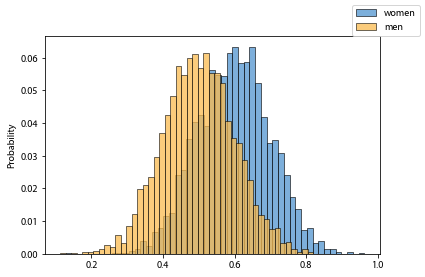

In [7]:
f,ax = plt.subplots(1,1,figsize=(6,4))
sns.histplot(np.random.normal(loc=walk_w[0],scale=walk_w[1],size=5000), color=colors[2], stat='probability')
sns.histplot(np.random.normal(loc=walk_m[0],scale=walk_m[1],size=5000), color=colors[3], stat='probability')
f.legend(labels=['women','men'])
plt.savefig('../data/img/beta_int1.pdf')

In [8]:
# generate authors
authors = []
for i in range(700): # we need this to be bigger than the number of authors used in the simulation, to make sure we dont run out when making random draws
    if np.random.rand(1)[0] >= woman_perc_f:
        gen = 'M'
    else:
        gen = 'W'
    # draw biases
    if gen == 'M':
        net = np.random.normal(loc=net_m[0],scale=net_m[1],size=1)[0]
        walk = np.random.normal(loc=walk_m[0],scale=walk_m[1],size=1)[0]
        meet = np.random.normal(loc=meet_m[0],scale=meet_m[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_m[0],sigma=learn_m[1],size=1)[0]
    else:
        net = np.random.normal(loc=net_w[0],scale=net_w[1],size=1)[0]
        walk = np.random.normal(loc=walk_w[0],scale=walk_w[1],size=1)[0]
        meet = np.random.normal(loc=meet_w[0],scale=meet_w[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_w[0],sigma=learn_w[1],size=1)[0]
    # make object
    a = Author(net,walk,meet,learn,gender=gen)
    a.init_network(g,node_2_gender,net_size_o,diam,c)
    authors.append(a)    

# simulate meetings
w_index = [a.gender == 'W' for a in authors]
w_ind = np.where(w_index)
m_ind = np.where([not x for x in w_index])
ns = np.round(np.linspace(nAuthSt, nAuth, nYears))
ns_w = np.round(ns*np.linspace(woman_perc_i, woman_perc_f, nYears))
# build up time vary parameters, like authors, and gender percentage
# initialize
sim_params = {}
w = np.random.choice(w_ind[0],(1,int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
m = np.random.choice(m_ind[0],(1,nAuthSt - int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
w.extend(m)
sim_params[0] = {'author_idx':w,
                    'woman_perc':woman_perc_i,
                    'n':nAuthSt,}
for i in range(1,nYears):
    new_n = ns[i]
    dn = new_n - sim_params[i-1]['n']
    dw = ns_w[i] - sum([a.gender == 'W' for a in [authors[x] for x in sim_params[i-1]['author_idx']]])
    rem_auths = [j for j,a in enumerate(authors) if j not in sim_params[i-1]['author_idx']]
    new_w_ind = [j for j,a in enumerate(authors) if (j in rem_auths) & (a.gender == 'W')]
    new_m_ind = [j for j,a in enumerate(authors) if (j in rem_auths) & (a.gender == 'M')]
    if dn > 0:
        a = []
        for j in range(int(dn)):
            if j <= dw:
                a.append(np.random.choice(new_w_ind).tolist())
            else:
                a.append(np.random.choice(new_m_ind).tolist())
        new_auths = sim_params[i-1]['author_idx'].copy()
        new_auths.extend(a)
        sim_params[i] = {'author_idx':new_auths,
                        'woman_perc':sum([a.gender == 'W' for a in [authors[x] for x in new_auths]])/new_n,
                        'n':new_n,}
    else:
        sim_params[i] = sim_params[i-1]

23it [04:05, 10.69s/it]


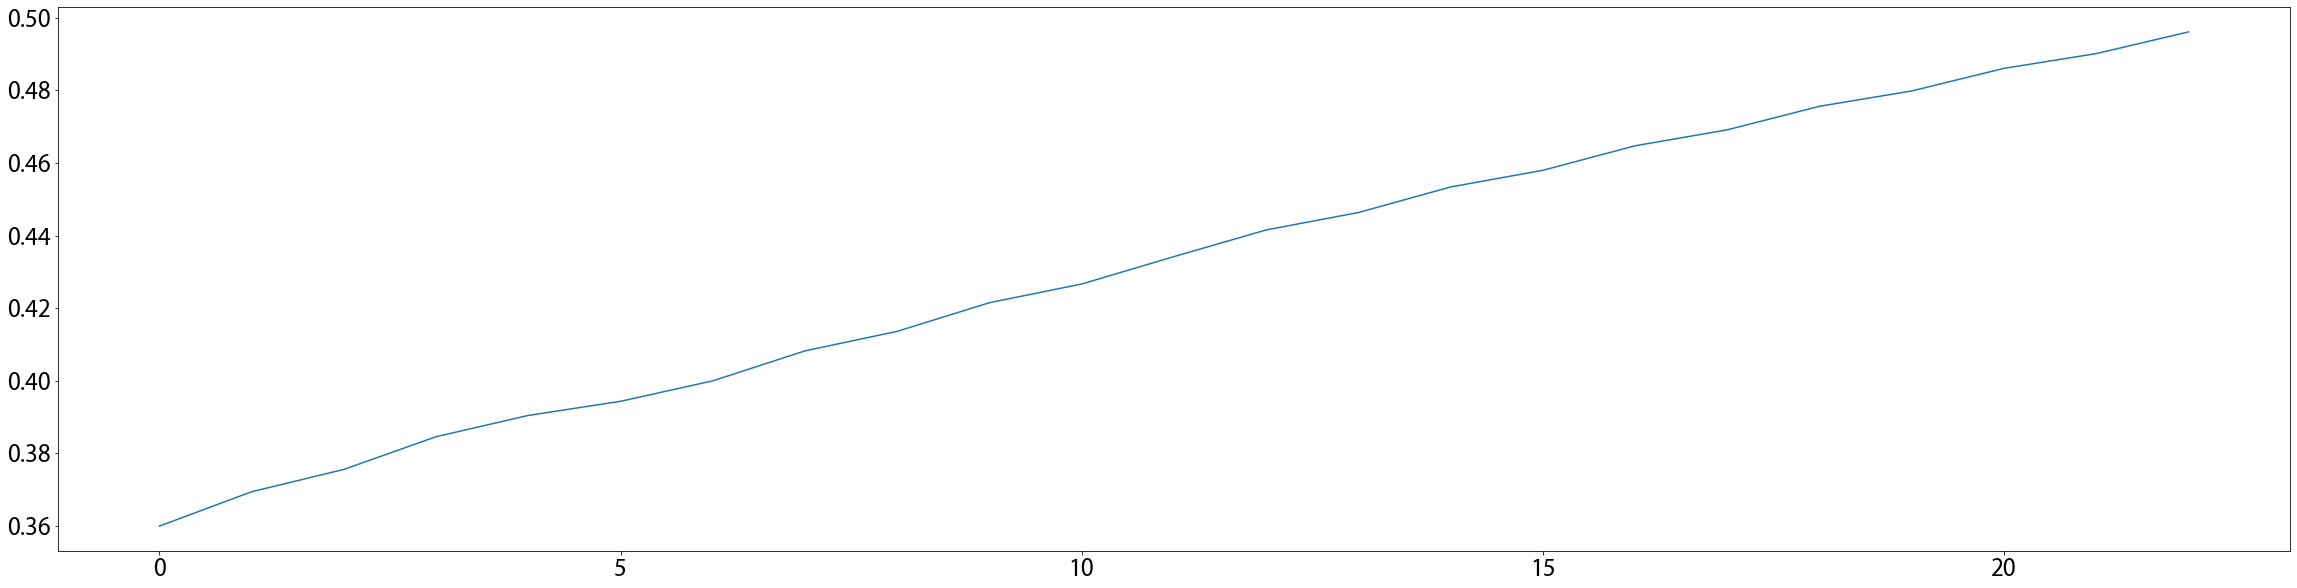

In [9]:
# proportion of women in the field
plt.rcParams.update({'font.size': 25})        
plt.figure(figsize=(40,10))
sns.lineplot(data=[x['woman_perc'] for x in sim_params.values()])

# run simulation
data = []
for i,b in tqdm(enumerate(range(nYears))):
    tmp = group_meet(sim_params[i]['n'], authors, sim_params[i]['author_idx'], meets_per_year)
    data.append(tmp)
    del tmp

In [10]:
# intialize final data structs
meets = {}; # keep track of when meetings were successful
citation_perc = []
citation_perc_w = []
citation_perc_m = []
net_size = []

# reformat data
meets = {}; # keep track of when meetings were successful
net_size = []
bibs = {}
bibs_w = {}
bibs_m = {}
cite_perc = []
percs = [x['woman_perc'] for x in sim_params.values()]

# reformat data
cite_data = pd.DataFrame(columns=['perc','gen','time'])
prac_data = pd.DataFrame(columns=['prac','time','gen','citer'])
for i,d in enumerate(data):    
    curr_meets, ns, bs, bws, bms = d
    curr_meets = dict(zip(np.array(list(curr_meets.keys()))+((i)*nAuth),curr_meets.values()))
    meets.update(curr_meets)
    net_size.append(ns)
    bibs[i] = bs
    bibs_w[i] = bws
    bibs_m[i] = bms

#### Plots

<AxesSubplot:>

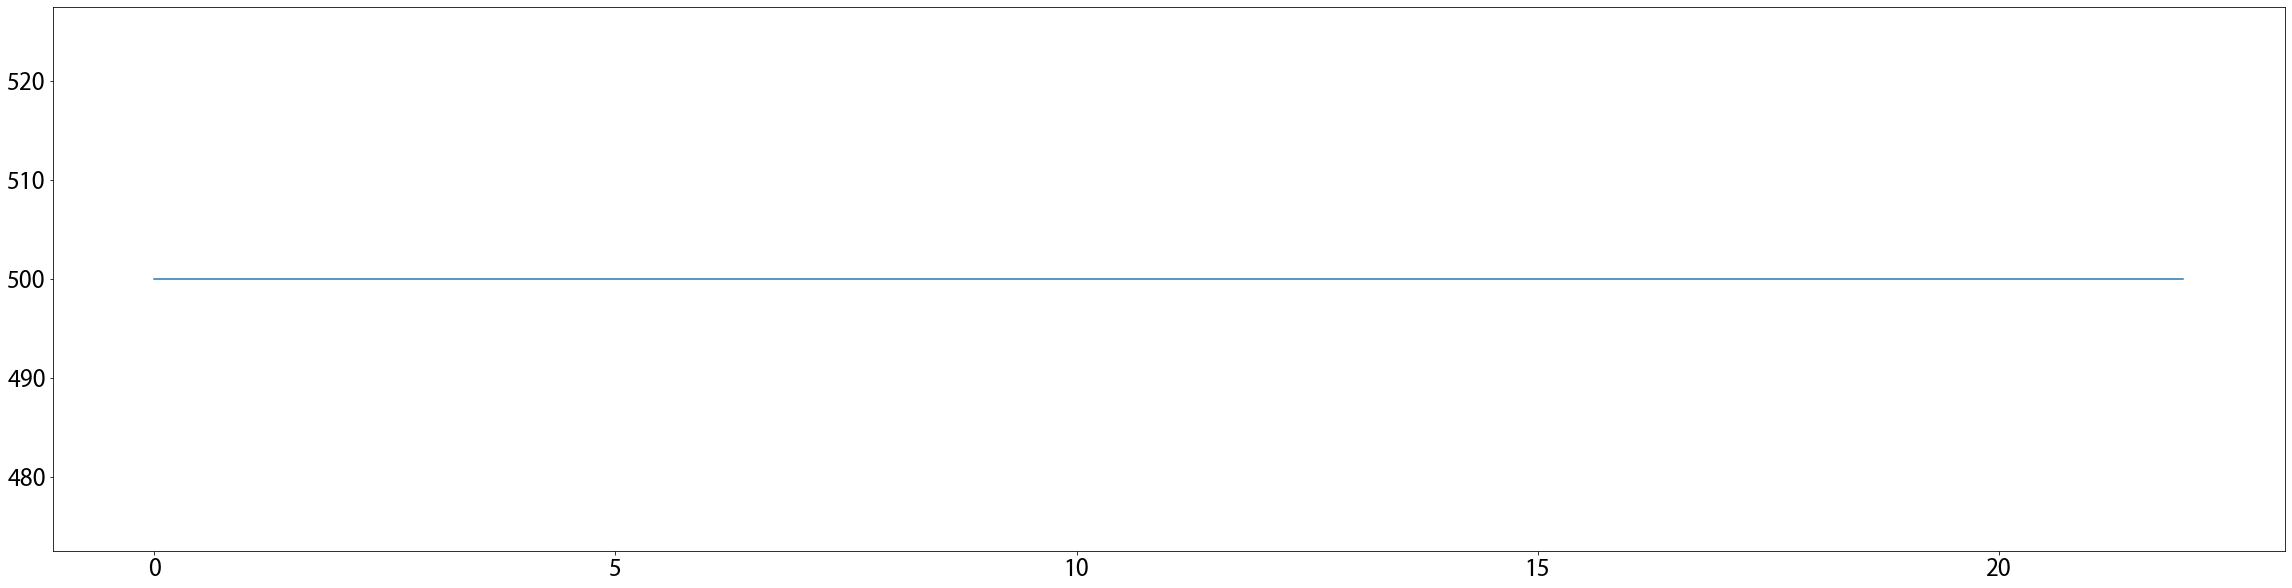

In [11]:
# network size
plt.figure(figsize=(40,10))
sns.lineplot(data=[x[0] for x in net_size])

Text(0.5, 1.0, 'Different Gender Meetings')

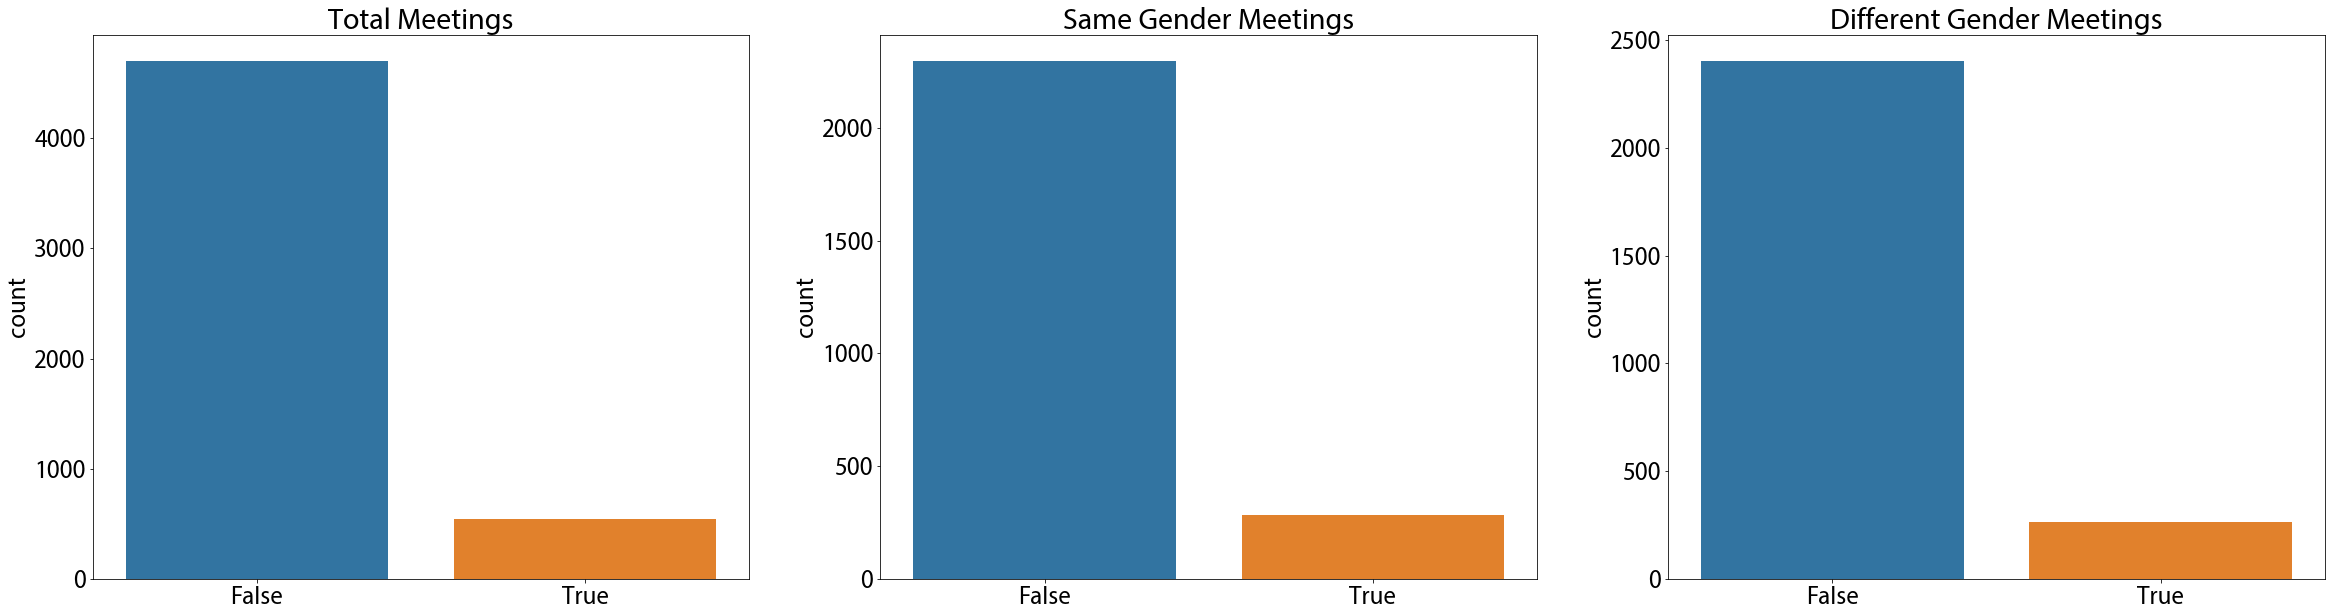

In [12]:
# number of meetings
plt.rcParams.update({'font.size': 25})        
f,ax = plt.subplots(1,3,figsize=(40,10))
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values()], ax=ax[0])
ax[0].set_title('Total Meetings')
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values() 
               if (x['gender1'] == x['gender2'])], ax=ax[1])
ax[1].set_title('Same Gender Meetings')
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values() 
                 if (x['gender1'] != x['gender2'])], ax=ax[2])
ax[2].set_title('Different Gender Meetings')

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


All citers (w): -0.19639093544371652%, +/-0.028236225752955896
All citers (m): 0.1604039316984456%, +/-0.022171381920428158
W citers (w): -0.003217586624935843%, +/-0.02976054202317764
W citers (m): 0.013194313057125307%, +/-0.023341779493238096
M citers (w): -0.34521658770720653%, +/-0.023029404641797268
M citers (m): 0.27381795929449315%, +/-0.01830487270143447


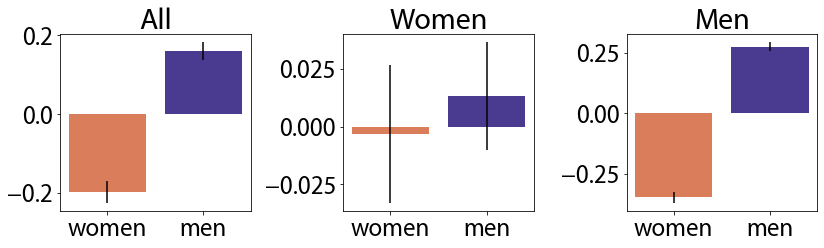

In [13]:
# static plot
static_perc = np.empty((nYears,len(bibs[nYears-1])))
static_perc[:] = np.NaN
static_perc_w = np.empty((nYears,len(bibs_w[nYears-1])))
static_perc_w[:] = np.NaN
static_perc_m = np.empty((nYears,len(bibs_m[nYears-1])))
static_perc_m[:] = np.NaN
for i,b in enumerate(bibs.values()):
    # get all authors citations at this time point
    for j,p in enumerate(b):
        # add to list
        static_perc[i][j] = np.mean([cite['gender'] == 'woman' for cite in p.values()])
        
for i,b in enumerate(bibs_w.values()):
    # get all w authors citations at this time point
    for j,p in enumerate(b):
        # add to list
        static_perc_w[i][j] = np.mean([cite['gender'] == 'woman' for cite in p.values()])

for i,b in enumerate(bibs_m.values()):
    # get all m authors citations at this time point
    for j,p in enumerate(b):
        # add to list
        static_perc_m[i][j] = np.mean([cite['gender'] == 'woman' for cite in p.values()])

plt.figure(figsize=(12,4))

plt.subplot(131)
amw = np.nanmean([(x-percs)/percs for x in static_perc.T])
asw = np.nanstd([(x-percs)/percs for x in static_perc.T])/np.sqrt(len(bibs[nYears-1]))
amm = np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T])
asm = np.nanstd([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T])/np.sqrt(len(bibs[nYears-1]))

plt.bar(['women','men'], [amw, amm], color=colors)
plt.errorbar(['women','men'], [amw,amm], [asw, asm], fmt='none', color='k')
plt.title('All')
print('All citers (w): ' + str(amw) + '%, +/-' + str(asw))
print('All citers (m): ' + str(amm) + '%, +/-' + str(asm))

plt.subplot(132)
wmw = np.nanmean([(x-percs)/percs for x in static_perc_w.T])
wsw = np.nanstd([(x-percs)/percs for x in static_perc_w.T])/np.sqrt(len(bibs[nYears-1]))
wmm = np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T])
wsm = np.nanstd([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T])/np.sqrt(len(bibs[nYears-1]))

plt.bar(['women','men'], [wmw, wmm], color=colors)
plt.errorbar(['women','men'], [wmw,wmm],[wsw,wsm], fmt='none', color='k')
plt.title('Women')
print('W citers (w): ' + str(wmw) + '%, +/-' + str(wsw))
print('W citers (m): ' + str(wmm) + '%, +/-' + str(wsm))

plt.subplot(133)
mmw = np.nanmean([(x-percs)/percs for x in static_perc_m.T])
msw = np.nanstd([(x-percs)/percs for x in static_perc_m.T])/np.sqrt(len(bibs[nYears-1]))
mmm = np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T])
msm = np.nanstd([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T])/np.sqrt(len(bibs[nYears-1]))

plt.bar(['women','men'], [mmw,mmm], color=colors)
plt.errorbar(['women','men'], [mmw,mmm],[msw,msm], fmt='none', color='k')
plt.title('Men')
print('M citers (w): ' + str(mmw) + '%, +/-' + str(msw))
print('M citers (m): ' + str(mmm) + '%, +/-' + str(msm))
plt.tight_layout()
plt.savefig('../data/img/static_cites_int1.pdf')

In [14]:
# stats
wt,wp = ttest_1samp(np.nanmean([(x-percs)/percs for x in static_perc.T],1),0)
mt,mp = ttest_1samp(np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T],1),0)
print('All citers (w): ' + str(wt) + ', ' + str(wp))
print('All citers (m): ' + str(mt) + ', ' + str(mp))

wt,wp = ttest_1samp(np.nanmean([(x-percs)/percs for x in static_perc_w.T],1),0)
mt,mp = ttest_1samp(np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T],1),0)
print('W citers (w): ' + str(wt) + ', ' + str(wp))
print('W citers (m): ' + str(mt) + ', ' + str(mp))

wt,wp = ttest_1samp(np.nanmean([(x-percs)/percs for x in static_perc_m.T],1),0)
mt,mp = ttest_1samp(np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T],1),0)
print('M citers (w): ' + str(wt) + ', ' + str(wp))
print('M citers (m): ' + str(mt) + ', ' + str(mp))

All citers (w): -11.456519588251238, 8.655243185731423e-25
All citers (m): 12.11798462886832, 5.373855087959802e-27
W citers (w): -1.198917327796128, 0.23281002254745584
W citers (m): 1.8750598635604325, 0.06309930407211277
M citers (w): -23.527000690948427, 2.5745858287118642e-48
M citers (m): 24.93592615582254, 5.654106297040567e-51


'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


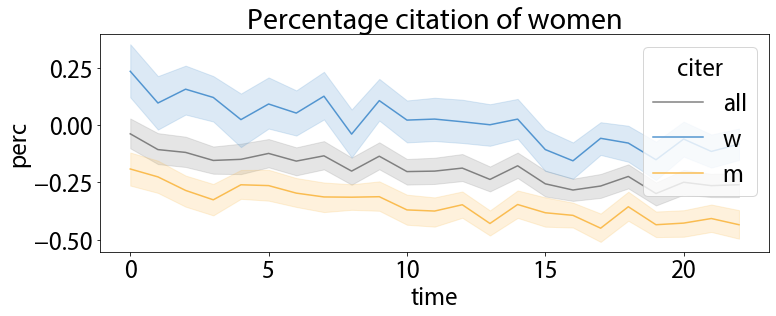

In [15]:
cite_data = pd.DataFrame(columns=['perc','gen','citer','time'])
for i,b in bibs.items():
    curr_perc = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
    tmp_data = pd.DataFrame({'perc': curr_perc, 
                             'gen':['w']*len(curr_perc),
                             'citer':['all']*len(curr_perc),
                             'time':[i]*len(curr_perc)})
    cite_data = pd.concat([cite_data,tmp_data])
    
for i,b in bibs_w.items():
    curr_perc_w = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
    curr_perc_m = (1 - (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b])) - (1 - percs[i]))/(1 - percs[i])    
    
    # womens citation by gender
    gen = ['w']*len(curr_perc_w)
    gen.extend(['m']*len(curr_perc_m))
    tmp_data = pd.DataFrame({'perc': np.concatenate((curr_perc_w, curr_perc_m)), 
                              'citer':['w']*(len(curr_perc_w)+len(curr_perc_m)),
                              'gen':gen,
                              'time':[i]*(len(curr_perc_w)+len(curr_perc_m))})    
    cite_data = pd.concat([cite_data,tmp_data])
    
for i,b in bibs_m.items():
    curr_perc_w = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
    curr_perc_m = (1 - (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b])) - (1 - percs[i]))/(1 - percs[i])    
    
    # mens citation by gender
    gen = ['w']*len(curr_perc_w)
    gen.extend(['m']*len(curr_perc_m))
    tmp_data = pd.DataFrame({'perc': np.concatenate((curr_perc_w, curr_perc_m)), 
                             'gen':gen, 
                             'citer':['m']*(len(curr_perc_w)+len(curr_perc_m)), 
                             'time':[i]*(len(curr_perc_w)+len(curr_perc_m))})    
    cite_data = pd.concat([cite_data,tmp_data])
    
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=cite_data[cite_data['gen'] == 'w'], x='time', y='perc', hue='citer',ax=ax, palette=['grey',colors[2],colors[3]])
ax.set_title('Percentage citation of women')
plt.savefig('../data/img/all_cite_w_int1.pdf')

In [16]:
# stats
X = sm.add_constant(range(nYears))
y = cite_data[(cite_data['citer'] == 'all') & (cite_data['gen'] == 'w')].groupby('time').mean().values
mod = sm.OLS(y, X)
res = mod.fit()
yw = cite_data[(cite_data['citer'] == 'w') & (cite_data['gen'] == 'w')].groupby('time').mean().values
modw = sm.OLS(yw, X)
resw = modw.fit()
ym = cite_data[(cite_data['citer'] == 'm') & (cite_data['gen'] == 'w')].groupby('time').mean().values
modm = sm.OLS(ym, X)
resm = modm.fit()

print('All citers: ' + str(res.params[1]) + ', ' + str(res.pvalues[1]))
print('W citers: ' + str(resw.params[1]) + ', ' + str(resw.pvalues[1]))
print('M citers: ' + str(resm.params[1]) + ', ' + str(resm.pvalues[1]))

All citers: -0.008852377041390722, 5.0587927297111705e-09
W citers: -0.01319152115384079, 9.914568660780568e-08
M citers: -0.009386074321790693, 7.623085898453644e-09


'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


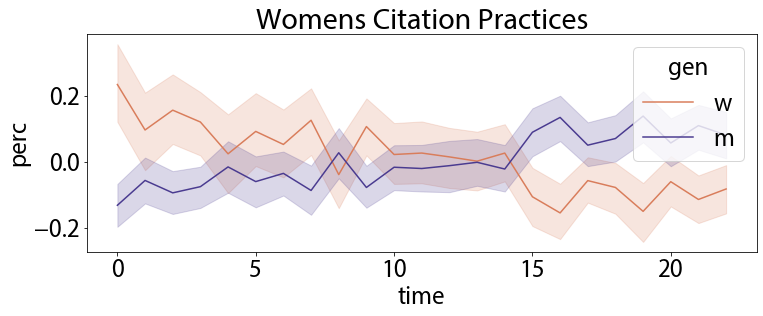

In [17]:
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=cite_data[cite_data['citer'] == 'w'], x='time', y='perc', hue='gen',ax=ax, palette=[colors[0],colors[1]])
ax.set_title('Womens Citation Practices')
plt.savefig('../data/img/w_cite_w_int1.pdf')

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


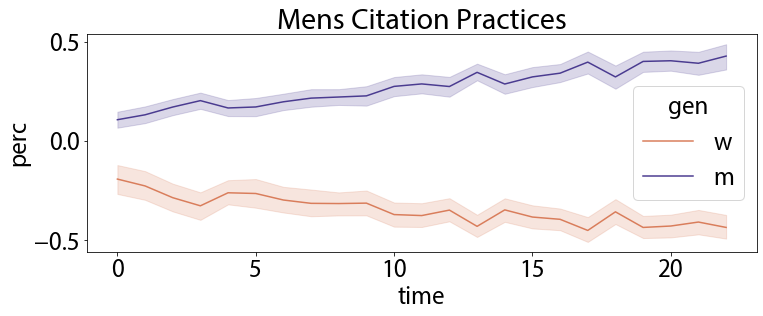

In [18]:
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=cite_data[cite_data['citer'] == 'm'], x='time', y='perc', hue='gen',ax=ax, palette=[colors[0],colors[1]])
ax.set_title('Mens Citation Practices')
plt.savefig('../data/img/m_cite_w_int1.pdf')

### Walk Bias - bias towards women

In [19]:
net_w = (.51,.01)
net_m = (.46,.01)
walk_w = (.60,.1)
walk_m = (.70,.1)
if meet_method == 'soc':
    meet_w = (0.04,0.005)
    meet_m = (0.05,0.005)
elif meet_method == 'bi':
    meet_w = (0.03,0.005)
    meet_m = (0.03,0.005)
learn_w = (-1,.75)
learn_m = (-1,.75)


'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


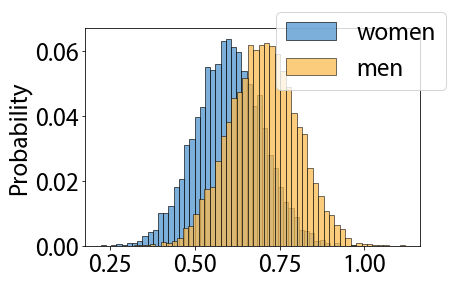

In [20]:
f,ax = plt.subplots(1,1,figsize=(6,4))
sns.histplot(np.random.normal(loc=walk_w[0],scale=walk_w[1],size=5000), color=colors[2], stat='probability')
sns.histplot(np.random.normal(loc=walk_m[0],scale=walk_m[1],size=5000), color=colors[3], stat='probability')
f.legend(labels=['women','men'])
plt.savefig('../data/img/beta_int2.pdf')

In [21]:
# generate authors
authors = []
for i in range(700): # we need this to be bigger than the number of authors used in the simulation, to make sure we dont run out when making random draws
    if np.random.rand(1)[0] >= woman_perc_f:
        gen = 'M'
    else:
        gen = 'W'
    # draw biases
    if gen == 'M':
        net = np.random.normal(loc=net_m[0],scale=net_m[1],size=1)[0]
        walk = 1.2
        while walk > 1:
            walk = np.random.normal(loc=walk_m[0],scale=walk_m[1],size=1)[0]
        meet = np.random.normal(loc=meet_m[0],scale=meet_m[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_m[0],sigma=learn_m[1],size=1)[0]
    else:
        net = np.random.normal(loc=net_w[0],scale=net_w[1],size=1)[0]
        walk = np.random.normal(loc=walk_w[0],scale=walk_w[1],size=1)[0]
        meet = np.random.normal(loc=meet_w[0],scale=meet_w[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_w[0],sigma=learn_w[1],size=1)[0]
    # make object
    a = Author(net,walk,meet,learn,gender=gen)
    a.init_network(g,node_2_gender,net_size_o,diam,c)
    authors.append(a)
    

# simulate meetings
w_index = [a.gender == 'W' for a in authors]
w_ind = np.where(w_index)
m_ind = np.where([not x for x in w_index])
ns = np.round(np.linspace(nAuthSt, nAuth, nYears))
ns_w = np.round(ns*np.linspace(woman_perc_i, woman_perc_f, nYears))
# build up time vary parameters, like authors, and gender percentage
# initialize
sim_params = {}
w = np.random.choice(w_ind[0],(1,int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
m = np.random.choice(m_ind[0],(1,nAuthSt - int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
w.extend(m)
sim_params[0] = {'author_idx':w,
                    'woman_perc':woman_perc_i,
                    'n':nAuthSt,}
for i in range(1,nYears):
    new_n = ns[i]
    dn = new_n - sim_params[i-1]['n']
    dw = ns_w[i] - sum([a.gender == 'W' for a in [authors[x] for x in sim_params[i-1]['author_idx']]])
    rem_auths = [j for j,a in enumerate(authors) if j not in sim_params[i-1]['author_idx']]
    new_w_ind = [j for j,a in enumerate(authors) if (j in rem_auths) & (a.gender == 'W')]
    new_m_ind = [j for j,a in enumerate(authors) if (j in rem_auths) & (a.gender == 'M')]
    if dn > 0:
        a = []
        for j in range(int(dn)):
            if j <= dw:
                a.append(np.random.choice(new_w_ind).tolist())
            else:
                a.append(np.random.choice(new_m_ind).tolist())
        new_auths = sim_params[i-1]['author_idx'].copy()
        new_auths.extend(a)
        sim_params[i] = {'author_idx':new_auths,
                        'woman_perc':sum([a.gender == 'W' for a in [authors[x] for x in new_auths]])/new_n,
                        'n':new_n,}
    else:
        sim_params[i] = sim_params[i-1]

23it [04:01, 10.52s/it]


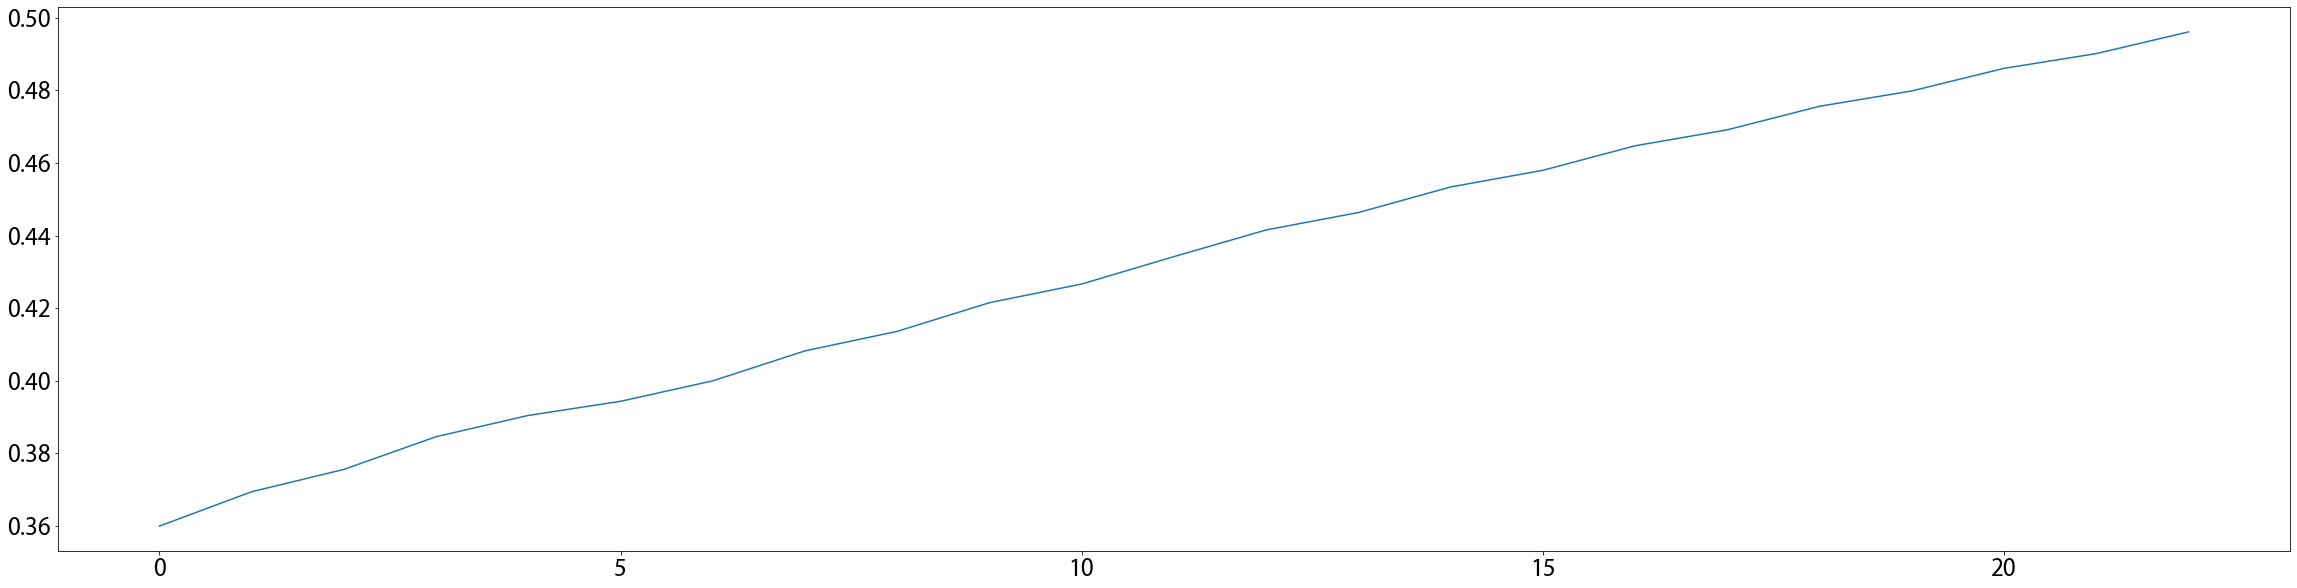

In [22]:
# proportion of women in the field
plt.rcParams.update({'font.size': 25})        
plt.figure(figsize=(40,10))
sns.lineplot(data=[x['woman_perc'] for x in sim_params.values()])

# run simulation
data = []
for i,b in tqdm(enumerate(range(nYears))):
    #cProfile.run("tmp = group_meet(sim_params[i]['n'], authors, sim_params[i]['author_idx'])")
    tmp = group_meet(sim_params[i]['n'], authors, sim_params[i]['author_idx'], meets_per_year)
    data.append(tmp)
    del tmp

# intialize final data structs
meets = {}; # keep track of when meetings were successful
net_size = []
bibs = {}
bibs_w = {}
bibs_m = {}
cite_perc = []
percs = [x['woman_perc'] for x in sim_params.values()]

# reformat data
cite_data = pd.DataFrame(columns=['perc','gen','time'])
prac_data = pd.DataFrame(columns=['prac','time','gen','citer'])
for i,d in enumerate(data):    
    curr_meets, ns, bs, bws, bms = d
    curr_meets = dict(zip(np.array(list(curr_meets.keys()))+((i)*nAuth),curr_meets.values()))
    meets.update(curr_meets)
    net_size.append(ns)
    bibs[i] = bs
    bibs_w[i] = bws
    bibs_m[i] = bms

#### Plots

<AxesSubplot:>

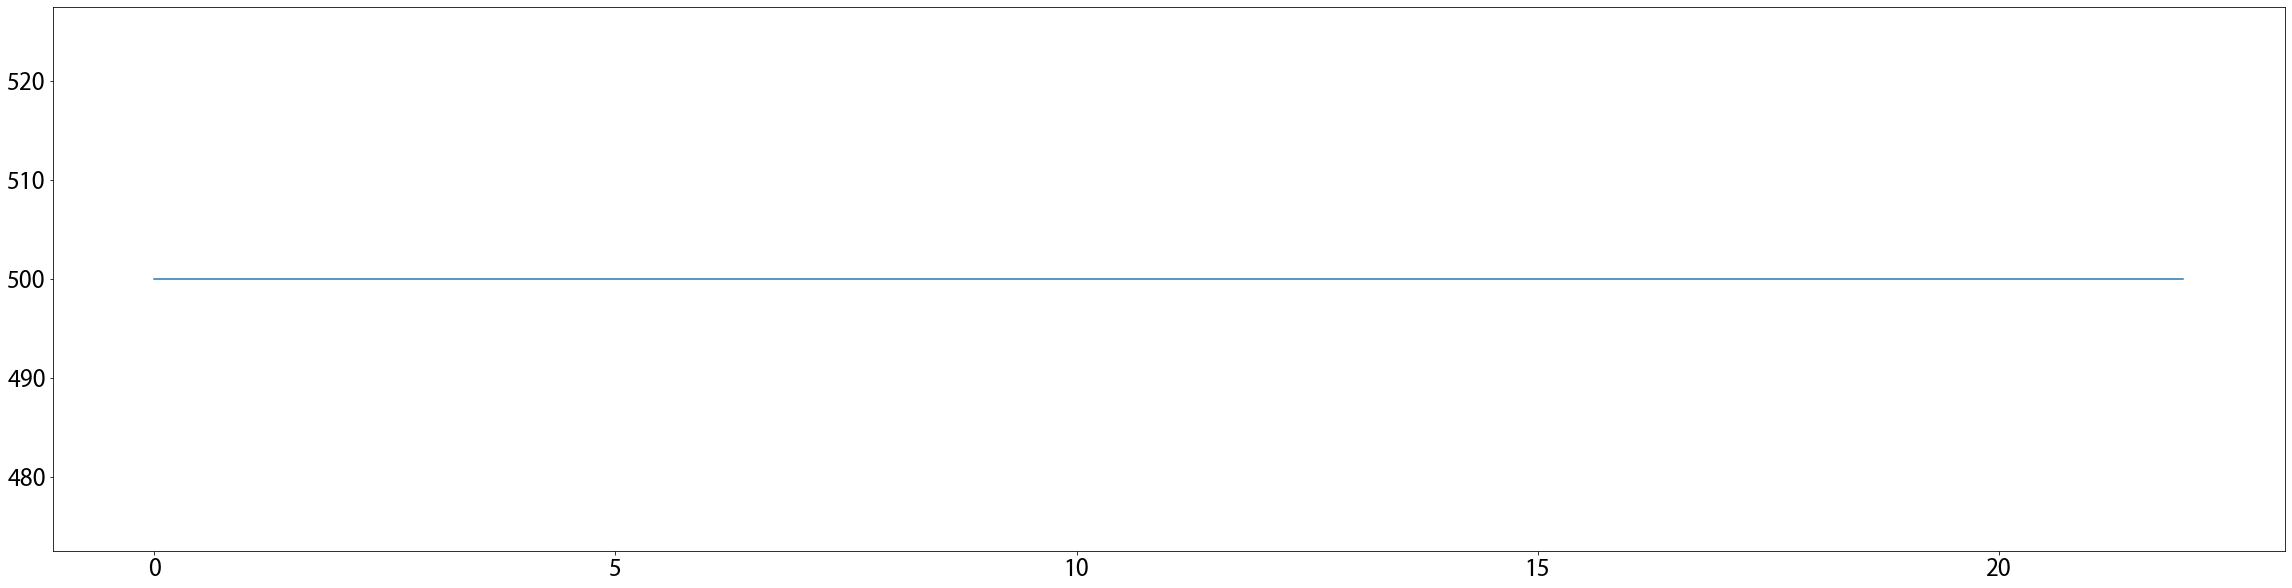

In [23]:
# network size
plt.figure(figsize=(40,10))
sns.lineplot(data=[x[0] for x in net_size])

Text(0.5, 1.0, 'Different Gender Meetings')

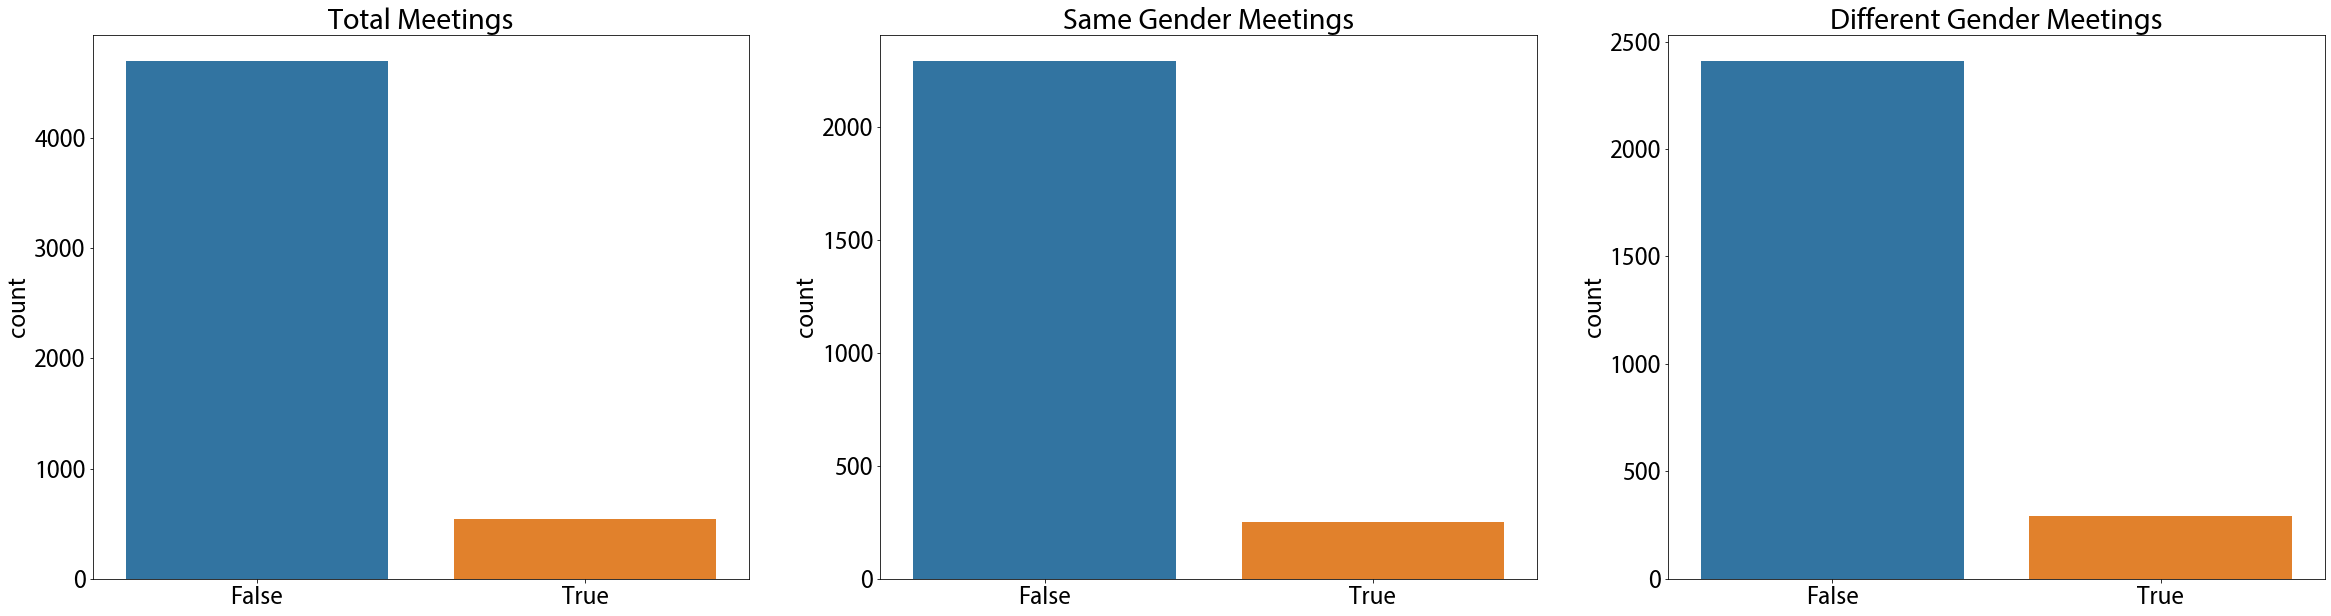

In [24]:
# number of meetings
plt.rcParams.update({'font.size': 25})        
f,ax = plt.subplots(1,3,figsize=(40,10))
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values()], ax=ax[0])
ax[0].set_title('Total Meetings')
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values() 
               if (x['gender1'] == x['gender2'])], ax=ax[1])
ax[1].set_title('Same Gender Meetings')
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values() 
                 if (x['gender1'] != x['gender2'])], ax=ax[2])
ax[2].set_title('Different Gender Meetings')

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


All citers (w): 0.024228979310630137%, +/-0.030354249384556626
All citers (m): -0.006332296360375181%, +/-0.023450057402726484
W citers (w): -0.027969479219316272%, +/-0.028992115691565047
W citers (m): 0.034127783066502%, +/-0.022721453993066656
M citers (w): 0.0644439969896773%, +/-0.031131055787094988
M citers (m): -0.03750376876150068%, +/-0.02381387713907585


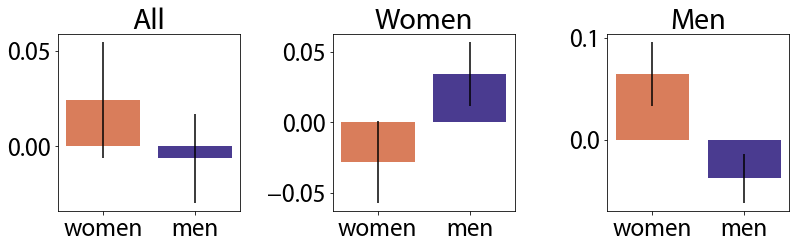

In [25]:
# static plot
static_perc = np.empty((nYears,len(bibs[nYears-1])))
static_perc[:] = np.NaN
static_perc_w = np.empty((nYears,len(bibs_w[nYears-1])))
static_perc_w[:] = np.NaN
static_perc_m = np.empty((nYears,len(bibs_m[nYears-1])))
static_perc_m[:] = np.NaN
for i,b in enumerate(bibs.values()):
    # get all authors citations at this time point
    for j,p in enumerate(b):
        # add to list
        static_perc[i][j] = np.mean([cite['gender'] == 'woman' for cite in p.values()])
        
for i,b in enumerate(bibs_w.values()):
    # get all w authors citations at this time point
    for j,p in enumerate(b):
        # add to list
        static_perc_w[i][j] = np.mean([cite['gender'] == 'woman' for cite in p.values()])

for i,b in enumerate(bibs_m.values()):
    # get all m authors citations at this time point
    for j,p in enumerate(b):
        # add to list
        static_perc_m[i][j] = np.mean([cite['gender'] == 'woman' for cite in p.values()])

plt.figure(figsize=(12,4))

plt.subplot(131)
amw = np.nanmean([(x-percs)/percs for x in static_perc.T])
asw = np.nanstd([(x-percs)/percs for x in static_perc.T])/np.sqrt(len(bibs[nYears-1]))
amm = np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T])
asm = np.nanstd([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T])/np.sqrt(len(bibs[nYears-1]))

plt.bar(['women','men'], [amw, amm], color=colors)
plt.errorbar(['women','men'], [amw,amm], [asw, asm], fmt='none', color='k')
plt.title('All')
print('All citers (w): ' + str(amw) + '%, +/-' + str(asw))
print('All citers (m): ' + str(amm) + '%, +/-' + str(asm))

plt.subplot(132)
wmw = np.nanmean([(x-percs)/percs for x in static_perc_w.T])
wsw = np.nanstd([(x-percs)/percs for x in static_perc_w.T])/np.sqrt(len(bibs[nYears-1]))
wmm = np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T])
wsm = np.nanstd([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T])/np.sqrt(len(bibs[nYears-1]))

plt.bar(['women','men'], [wmw, wmm], color=colors)
plt.errorbar(['women','men'], [wmw,wmm],[wsw,wsm], fmt='none', color='k')
plt.title('Women')
print('W citers (w): ' + str(wmw) + '%, +/-' + str(wsw))
print('W citers (m): ' + str(wmm) + '%, +/-' + str(wsm))

plt.subplot(133)
mmw = np.nanmean([(x-percs)/percs for x in static_perc_m.T])
msw = np.nanstd([(x-percs)/percs for x in static_perc_m.T])/np.sqrt(len(bibs[nYears-1]))
mmm = np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T])
msm = np.nanstd([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T])/np.sqrt(len(bibs[nYears-1]))

plt.bar(['women','men'], [mmw,mmm], color=colors)
plt.errorbar(['women','men'], [mmw,mmm],[msw,msm], fmt='none', color='k')
plt.title('Men')
print('M citers (w): ' + str(mmw) + '%, +/-' + str(msw))
print('M citers (m): ' + str(mmm) + '%, +/-' + str(msm))
plt.tight_layout()
plt.savefig('../data/img/static_cites_int2.pdf')

In [26]:
# stats
wt,wp = ttest_1samp(np.nanmean([(x-percs)/percs for x in static_perc.T],1),0)
mt,mp = ttest_1samp(np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T],1),0)
print('All citers (w): ' + str(wt) + ', ' + str(wp))
print('All citers (m): ' + str(mt) + ', ' + str(mp))

wt,wp = ttest_1samp(np.nanmean([(x-percs)/percs for x in static_perc_w.T],1),0)
mt,mp = ttest_1samp(np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T],1),0)
print('W citers (w): ' + str(wt) + ', ' + str(wp))
print('W citers (m): ' + str(mt) + ', ' + str(mp))

wt,wp = ttest_1samp(np.nanmean([(x-percs)/percs for x in static_perc_m.T],1),0)
mt,mp = ttest_1samp(np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T],1),0)
print('M citers (w): ' + str(wt) + ', ' + str(wp))
print('M citers (m): ' + str(mt) + ', ' + str(mp))

All citers (w): 0.4969894034194154, 0.6196247313652792
All citers (m): 0.6429756583419264, 0.5208176285023403
W citers (w): -2.4854519137977795, 0.014249040621584984
W citers (m): 3.2983962324099605, 0.001264195583535756
M citers (w): 2.886865026273129, 0.004568995241030068
M citers (m): -2.2266259872028473, 0.027720734087758006


'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


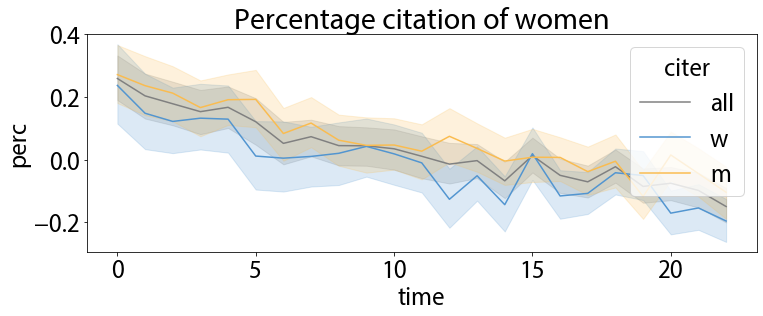

In [27]:
cite_data = pd.DataFrame(columns=['perc','gen','citer','time'])
for i,b in bibs.items():
    curr_perc = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
    tmp_data = pd.DataFrame({'perc': curr_perc, 
                             'gen':['w']*len(curr_perc),
                             'citer':['all']*len(curr_perc),
                             'time':[i]*len(curr_perc)})
    cite_data = pd.concat([cite_data,tmp_data])
    
for i,b in bibs_w.items():
    curr_perc_w = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
    curr_perc_m = (1 - (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b])) - (1 - percs[i]))/(1 - percs[i])    
    
    # womens citation by gender
    gen = ['w']*len(curr_perc_w)
    gen.extend(['m']*len(curr_perc_m))
    tmp_data = pd.DataFrame({'perc': np.concatenate((curr_perc_w, curr_perc_m)), 
                              'citer':['w']*(len(curr_perc_w)+len(curr_perc_m)),
                              'gen':gen,
                              'time':[i]*(len(curr_perc_w)+len(curr_perc_m))})    
    cite_data = pd.concat([cite_data,tmp_data])
    
for i,b in bibs_m.items():
    curr_perc_w = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
    curr_perc_m = (1 - (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b])) - (1 - percs[i]))/(1 - percs[i])    
    
    # mens citation by gender
    gen = ['w']*len(curr_perc_w)
    gen.extend(['m']*len(curr_perc_m))
    tmp_data = pd.DataFrame({'perc': np.concatenate((curr_perc_w, curr_perc_m)), 
                             'gen':gen, 
                             'citer':['m']*(len(curr_perc_w)+len(curr_perc_m)), 
                             'time':[i]*(len(curr_perc_w)+len(curr_perc_m))})    
    cite_data = pd.concat([cite_data,tmp_data])
    
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=cite_data[cite_data['gen'] == 'w'], x='time', y='perc', hue='citer',ax=ax, palette=['grey',colors[2],colors[3]])
ax.set_title('Percentage citation of women')
plt.savefig('../data/img/all_cite_w_int2.pdf')

In [28]:
# stats
X = sm.add_constant(range(nYears))
y = cite_data[(cite_data['citer'] == 'all') & (cite_data['gen'] == 'w')].groupby('time').mean().values
mod = sm.OLS(y, X)
res = mod.fit()
yw = cite_data[(cite_data['citer'] == 'w') & (cite_data['gen'] == 'w')].groupby('time').mean().values
modw = sm.OLS(yw, X)
resw = modw.fit()
ym = cite_data[(cite_data['citer'] == 'm') & (cite_data['gen'] == 'w')].groupby('time').mean().values
modm = sm.OLS(ym, X)
resm = modm.fit()

print('All citers: ' + str(res.params[1]) + ', ' + str(res.pvalues[1]))
print('W citers: ' + str(resw.params[1]) + ', ' + str(resw.pvalues[1]))
print('M citers: ' + str(resm.params[1]) + ', ' + str(resm.pvalues[1]))

All citers: -0.015231373281372218, 5.604553530283321e-13
W citers: -0.015004479977876078, 1.209941749679543e-08
M citers: -0.01457369109547856, 5.7740272023852626e-11


'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


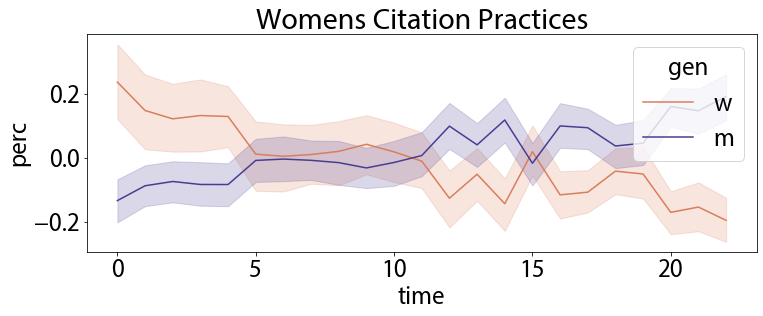

In [29]:
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=cite_data[cite_data['citer'] == 'w'], x='time', y='perc', hue='gen',ax=ax, palette=[colors[0],colors[1]])
ax.set_title('Womens Citation Practices')
plt.savefig('../data/img/w_cite_w_int2.pdf')

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


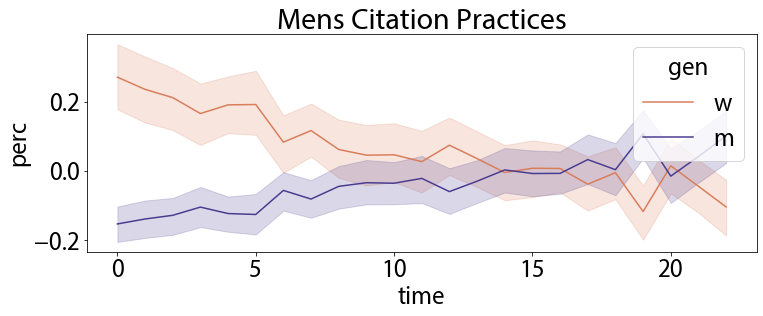

In [30]:
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=cite_data[cite_data['citer'] == 'm'], x='time', y='perc', hue='gen',ax=ax, palette=[colors[0],colors[1]])
ax.set_title('Mens Citation Practices')
plt.savefig('../data/img/m_cite_w_int2.pdf')

#### Parameter sweeps

In [31]:
import cProfile

# parameter range we are interested in
parameter = np.linspace(0.4,0.8,10)
statics = []
slopes = []

# generate authors
authors_orig = []
for i in range(700): # we need this to be bigger than the number of authors used in the simulation, to make sure we dont run out when making random draws
    if np.random.rand(1)[0] >= woman_perc_f:
        gen = 'M'
    else:
        gen = 'W'
    # draw biases
    if gen == 'M':
        net = np.random.normal(loc=net_m[0],scale=net_m[1],size=1)[0]
        walk = 1.2
        while walk > 1:
            walk = np.random.normal(loc=walk_m[0],scale=walk_m[1],size=1)[0]
        meet = np.random.normal(loc=meet_m[0],scale=meet_m[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_m[0],sigma=learn_m[1],size=1)[0]
    else:
        net = np.random.normal(loc=net_w[0],scale=net_w[1],size=1)[0]
        walk = np.random.normal(loc=walk_w[0],scale=walk_w[1],size=1)[0]
        meet = np.random.normal(loc=meet_w[0],scale=meet_w[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_w[0],sigma=learn_w[1],size=1)[0]
    # make object
    a = Author(net,walk,meet,learn,gender=gen)
    a.init_network(g,node_2_gender,net_size_o,diam,c)
    authors_orig.append(a)
    
# simulate meetings
w_index = [a.gender == 'W' for a in authors_orig]
w_ind = np.where(w_index)
m_ind = np.where([not x for x in w_index])
ns = np.round(np.linspace(nAuthSt, nAuth, nYears))
ns_w = np.round(ns*np.linspace(woman_perc_i, woman_perc_f, nYears))
# build up time vary parameters, like authors, and gender percentage
# initialize
sim_params = {}
w = np.random.choice(w_ind[0],(1,int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
m = np.random.choice(m_ind[0],(1,nAuthSt - int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
w.extend(m)
sim_params[0] = {'author_idx':w,
                    'woman_perc':woman_perc_i,
                    'n':nAuthSt,}
for i in range(1,nYears):
    new_n = ns[i]
    dn = new_n - sim_params[i-1]['n']
    dw = ns_w[i] - sum([a.gender == 'W' for a in [authors_orig[x] for x in sim_params[i-1]['author_idx']]])
    rem_auths = [j for j,a in enumerate(authors_orig) if j not in sim_params[i-1]['author_idx']]
    new_w_ind = [j for j,a in enumerate(authors_orig) if (j in rem_auths) & (a.gender == 'W')]
    new_m_ind = [j for j,a in enumerate(authors_orig) if (j in rem_auths) & (a.gender == 'M')]
    if dn > 0:
        a = []
        for j in range(int(dn)):
            if j <= dw:
                a.append(np.random.choice(new_w_ind).tolist())
            else:
                a.append(np.random.choice(new_m_ind).tolist())
        new_auths = sim_params[i-1]['author_idx'].copy()
        new_auths.extend(a)
        sim_params[i] = {'author_idx':new_auths,
                        'woman_perc':sum([a.gender == 'W' for a in [authors[x] for x in new_auths]])/new_n,
                        'n':new_n,}
    else:
        sim_params[i] = sim_params[i-1]

In [32]:
# loop through the new parameters
data = Parallel(n_jobs=4)(
    delayed(param_sweep)(authors_orig, 'walk', p)
    for p in tqdm(parameter) 
)
    

100%|██████████| 10/10 [05:37<00:00, 33.73s/it]


'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


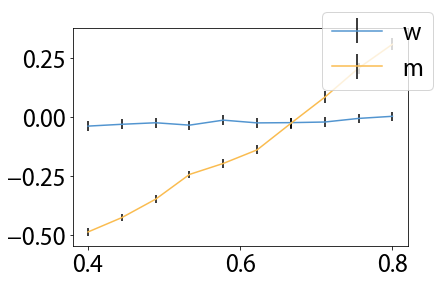

In [33]:
# plot parameter sweep
# static differences over time
statics = [d[1] for d in data]
fig = plt.figure(figsize=(6,4))
w_cite = [x[0]['wmu'] for x in statics]
w_err = [x[0]['wstd'] for x in statics]
m_cite = [x[0]['mmu'] for x in statics]
m_err = [x[0]['mstd'] for x in statics]

plt.errorbar(parameter, w_cite, np.abs(np.concatenate((np.array(w_err).reshape(-1,1), 
                                                -np.array(w_err).reshape(-1,1)), axis=1).T), label='w', 
             color=colors[2], ecolor='black')
plt.errorbar(parameter, m_cite, np.abs(np.concatenate((np.array(m_err).reshape(-1,1), 
                                                -np.array(m_err).reshape(-1,1)), axis=1).T), label='m', 
             color=colors[3], ecolor='black')
fig.legend()
plt.savefig('../data/img/static_ps_walk.pdf')

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


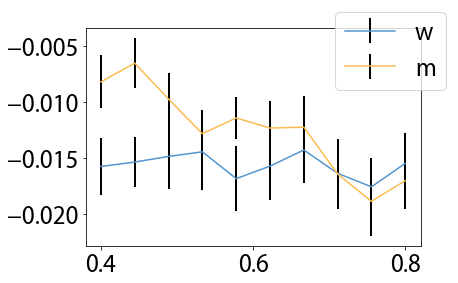

In [34]:
# plot slopes of W cites
slopes = [d[0] for d in data]
fig = plt.figure(figsize=(6,4))
w_slope = [x[0]['wslope'] for x in slopes]
w_err = [x[0]['wci'] for x in slopes]
m_slope = [x[0]['mslope'] for x in slopes]
m_err = [x[0]['mci'] for x in slopes]
w_err = np.array(w_err).T - w_slope
m_err = np.array(m_err).T - m_slope

plt.errorbar(parameter, w_slope, np.abs(w_err), label='w', color=colors[2], ecolor='black', elinewidth=2)
plt.errorbar(parameter, m_slope, np.abs(m_err), label='m', color=colors[3], ecolor='black', elinewidth=2)
fig.legend()
plt.savefig('../data/img/tv_ps_walk.pdf')

### Meet bias - more openness

In [20]:
net_w = (.51,.01)
net_m = (.46,.01)
walk_w = (.60,.1)
walk_m = (.44,.1)
if meet_method == 'soc':
    meet_w = (0.04,0.005)
    meet_m = (0.01,0.0006)
elif meet_method == 'bi':
    meet_w = (0.03,0.005)
    meet_m = (0.03,0.005)
learn_w = (-1,.75)
learn_m = (-1,.75)


'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


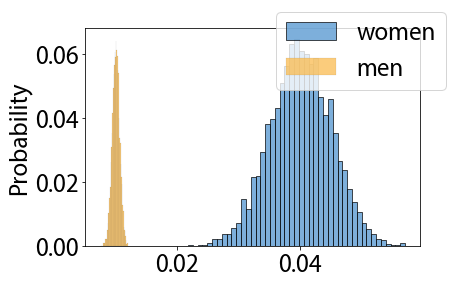

In [21]:
f,ax = plt.subplots(1,1,figsize=(6,4))
sns.histplot(np.random.normal(loc=meet_w[0],scale=meet_w[1],size=5000), color=colors[2], stat='probability')
sns.histplot(np.random.normal(loc=meet_m[0],scale=meet_m[1],size=5000), color=colors[3], stat='probability')
f.legend(labels=['women','men'])
plt.savefig('../data/img/gamma_int3.pdf')

In [22]:
# generate authors
authors = []
for i in range(700): # we need this to be bigger than the number of authors used in the simulation, to make sure we dont run out when making random draws
    if np.random.rand(1)[0] >= woman_perc_f:
        gen = 'M'
    else:
        gen = 'W'
    # draw biases
    if gen == 'M':
        net = np.random.normal(loc=net_m[0],scale=net_m[1],size=1)[0]
        walk = np.random.normal(loc=walk_m[0],scale=walk_m[1],size=1)[0]
        meet = np.random.normal(loc=meet_m[0],scale=meet_m[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_m[0],sigma=learn_m[1],size=1)[0]
    else:
        net = np.random.normal(loc=net_w[0],scale=net_w[1],size=1)[0]
        walk = np.random.normal(loc=walk_w[0],scale=walk_w[1],size=1)[0]
        meet = np.random.normal(loc=meet_w[0],scale=meet_w[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_w[0],sigma=learn_w[1],size=1)[0]
    # make object
    a = Author(net,walk,meet,learn,gender=gen)
    a.init_network(g,node_2_gender,net_size_o,diam,c)
    authors.append(a)
    

# simulate meetings
w_index = [a.gender == 'W' for a in authors]
w_ind = np.where(w_index)
m_ind = np.where([not x for x in w_index])
ns = np.round(np.linspace(nAuthSt, nAuth, nYears))
ns_w = np.round(ns*np.linspace(woman_perc_i, woman_perc_f, nYears))
# build up time vary parameters, like authors, and gender percentage
# initialize
sim_params = {}
w = np.random.choice(w_ind[0],(1,int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
m = np.random.choice(m_ind[0],(1,nAuthSt - int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
w.extend(m)
sim_params[0] = {'author_idx':w,
                    'woman_perc':woman_perc_i,
                    'n':nAuthSt,}
for i in range(1,nYears):
    new_n = ns[i]
    dn = new_n - sim_params[i-1]['n']
    dw = ns_w[i] - sum([a.gender == 'W' for a in [authors[x] for x in sim_params[i-1]['author_idx']]])
    rem_auths = [j for j,a in enumerate(authors) if j not in sim_params[i-1]['author_idx']]
    new_w_ind = [j for j,a in enumerate(authors) if (j in rem_auths) & (a.gender == 'W')]
    new_m_ind = [j for j,a in enumerate(authors) if (j in rem_auths) & (a.gender == 'M')]
    if dn > 0:
        a = []
        for j in range(int(dn)):
            if j <= dw:
                a.append(np.random.choice(new_w_ind).tolist())
            else:
                a.append(np.random.choice(new_m_ind).tolist())
        new_auths = sim_params[i-1]['author_idx'].copy()
        new_auths.extend(a)
        sim_params[i] = {'author_idx':new_auths,
                        'woman_perc':sum([a.gender == 'W' for a in [authors[x] for x in new_auths]])/new_n,
                        'n':new_n,}
    else:
        sim_params[i] = sim_params[i-1]

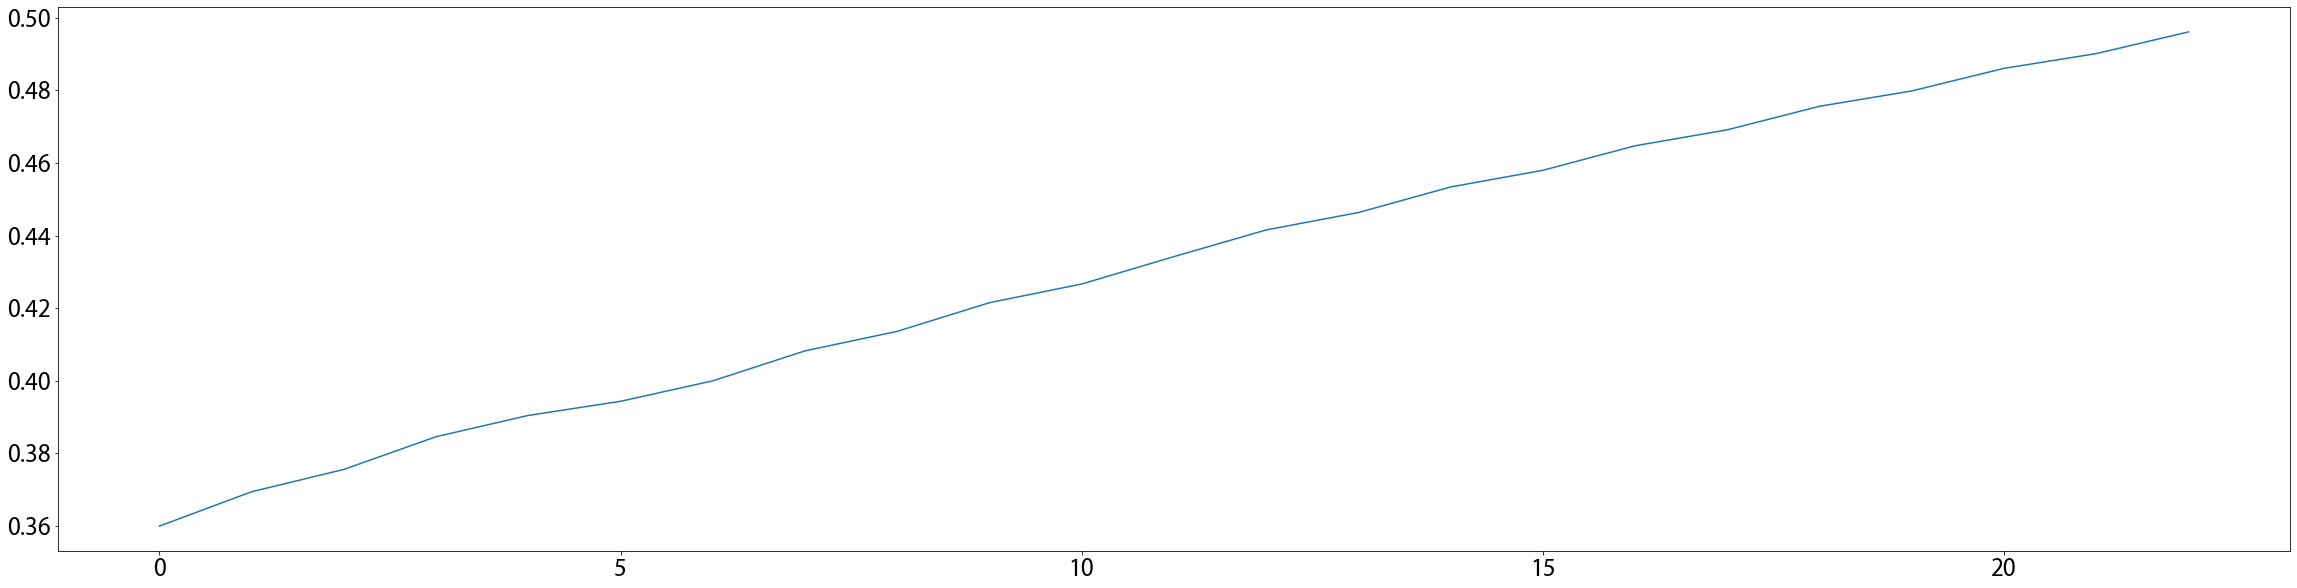

In [23]:
# proportion of women in the field
plt.rcParams.update({'font.size': 25})        
plt.figure(figsize=(40,10))
sns.lineplot(data=[x['woman_perc'] for x in sim_params.values()])

# run simulation
data = []
for i,b in enumerate(range(nYears)):
    #cProfile.run("tmp = group_meet(sim_params[i]['n'], authors, sim_params[i]['author_idx'])")
    tmp = group_meet(sim_params[i]['n'], authors, sim_params[i]['author_idx'], meets_per_year)
    data.append(tmp)
    del tmp

# intialize final data structs
meets = {}; # keep track of when meetings were successful
net_size = []
bibs = {}
bibs_w = {}
bibs_m = {}
cite_perc = []
percs = [x['woman_perc'] for x in sim_params.values()]

# reformat data
cite_data = pd.DataFrame(columns=['perc','gen','time'])
prac_data = pd.DataFrame(columns=['prac','time','gen','citer'])
for i,d in enumerate(data):    
    curr_meets, ns, bs, bws, bms = d
    curr_meets = dict(zip(np.array(list(curr_meets.keys()))+((i)*nAuth),curr_meets.values()))
    meets.update(curr_meets)
    net_size.append(ns)
    bibs[i] = bs
    bibs_w[i] = bws
    bibs_m[i] = bms


#### Plots

<AxesSubplot:>

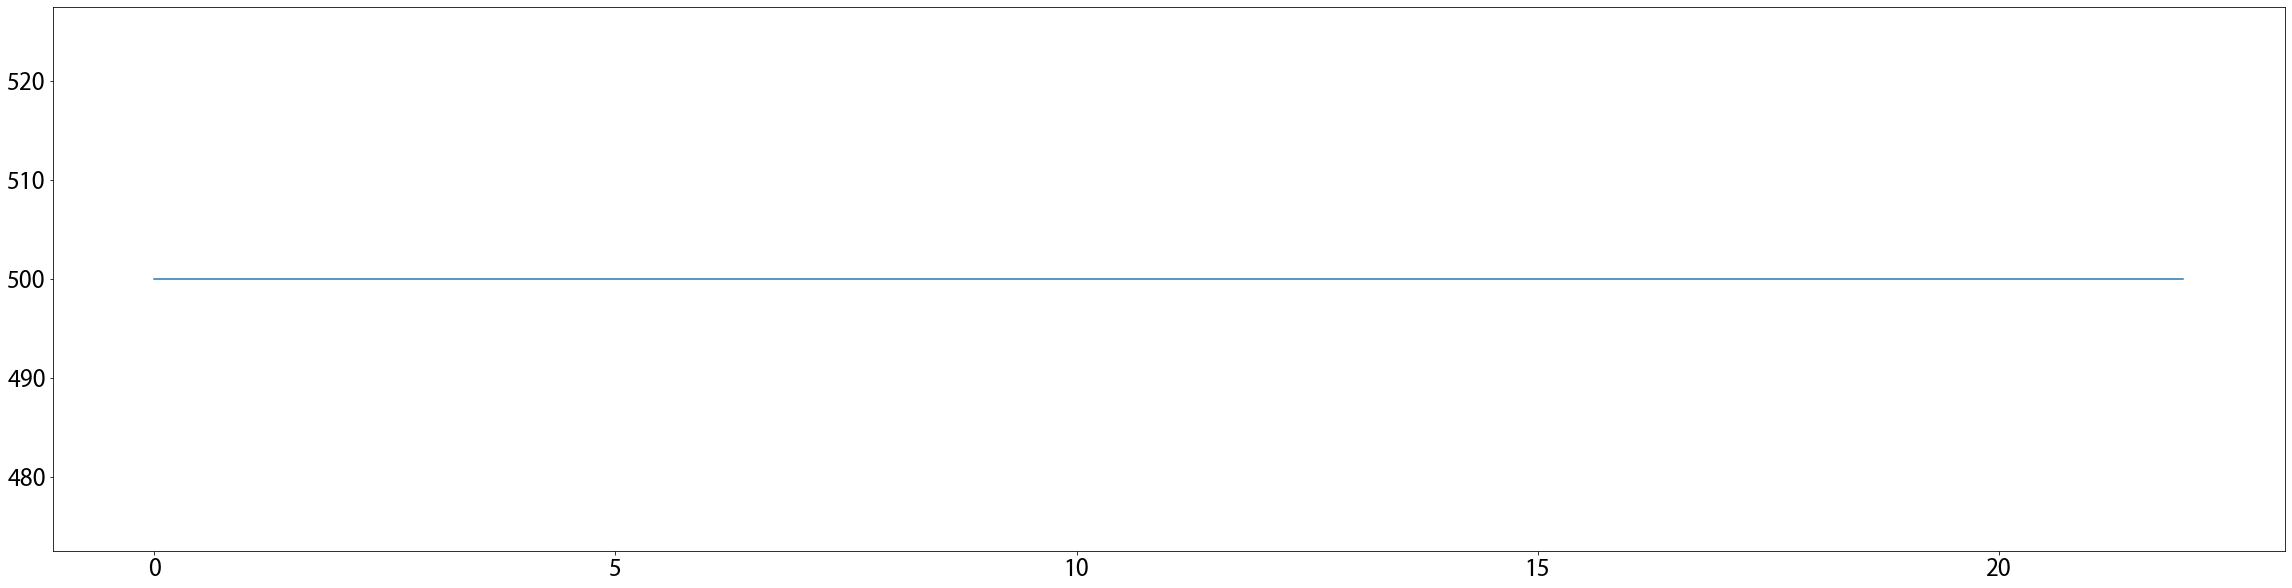

In [24]:
# network size
plt.figure(figsize=(40,10))
sns.lineplot(data=[x[0] for x in net_size])

Text(0.5, 1.0, 'Different Gender Meetings')

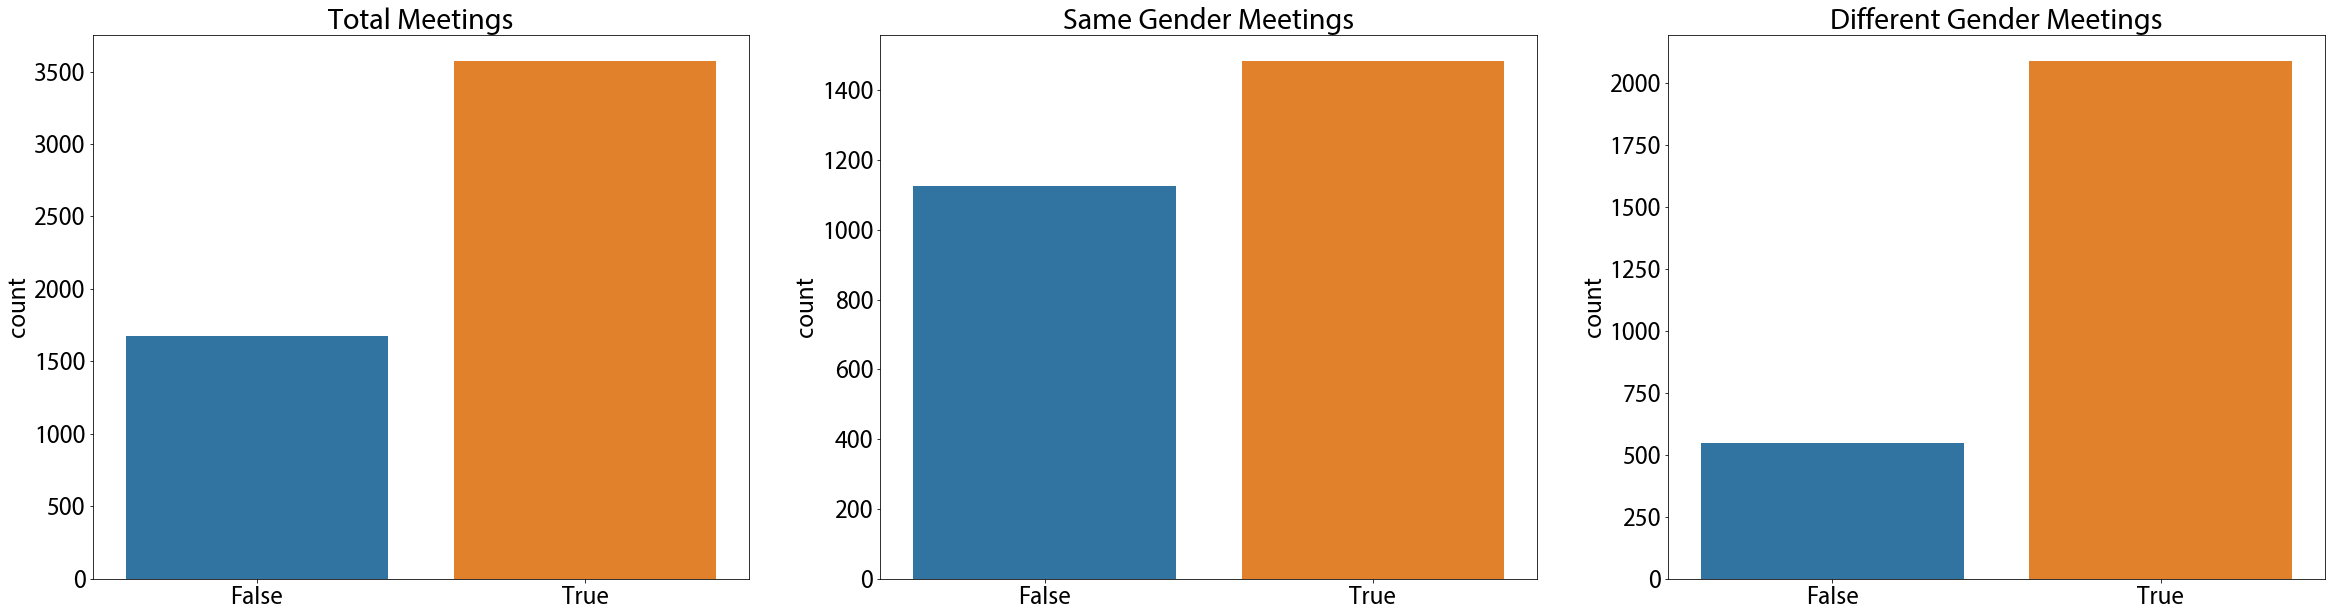

In [25]:
# number of meetings
plt.rcParams.update({'font.size': 25})        
f,ax = plt.subplots(1,3,figsize=(40,10))
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values()], ax=ax[0])
ax[0].set_title('Total Meetings')
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values() 
               if (x['gender1'] == x['gender2'])], ax=ax[1])
ax[1].set_title('Same Gender Meetings')
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values() 
                 if (x['gender1'] != x['gender2'])], ax=ax[2])
ax[2].set_title('Different Gender Meetings')

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


All citers (w): -0.15931346316024544%, +/-0.03248605382922746
All citers (m): 0.12923735251225427%, +/-0.02549471149960643
W citers (w): -0.023927991360860112%, +/-0.02880811570499478
W citers (m): 0.030682671786796647%, +/-0.022975865662378102
M citers (w): -0.2636178678348563%, +/-0.03363579066713398
M citers (m): 0.20516638067413617%, +/-0.026311404440327132


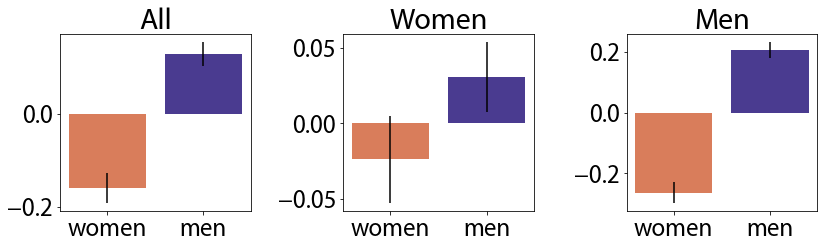

In [26]:
# static plot
static_perc = np.empty((nYears,len(bibs[nYears-1])))
static_perc[:] = np.NaN
static_perc_w = np.empty((nYears,len(bibs_w[nYears-1])))
static_perc_w[:] = np.NaN
static_perc_m = np.empty((nYears,len(bibs_m[nYears-1])))
static_perc_m[:] = np.NaN
for i,b in enumerate(bibs.values()):
    # get all authors citations at this time point
    for j,p in enumerate(b):
        # add to list
        static_perc[i][j] = np.mean([cite['gender'] == 'woman' for cite in p.values()])
        
for i,b in enumerate(bibs_w.values()):
    # get all w authors citations at this time point
    for j,p in enumerate(b):
        # add to list
        static_perc_w[i][j] = np.mean([cite['gender'] == 'woman' for cite in p.values()])

for i,b in enumerate(bibs_m.values()):
    # get all m authors citations at this time point
    for j,p in enumerate(b):
        # add to list
        static_perc_m[i][j] = np.mean([cite['gender'] == 'woman' for cite in p.values()])

plt.figure(figsize=(12,4))

plt.subplot(131)
amw = np.nanmean([(x-percs)/percs for x in static_perc.T])
asw = np.nanstd([(x-percs)/percs for x in static_perc.T])/np.sqrt(len(bibs[nYears-1]))
amm = np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T])
asm = np.nanstd([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T])/np.sqrt(len(bibs[nYears-1]))

plt.bar(['women','men'], [amw, amm], color=colors)
plt.errorbar(['women','men'], [amw,amm], [asw, asm], fmt='none', color='k')
plt.title('All')
print('All citers (w): ' + str(amw) + '%, +/-' + str(asw))
print('All citers (m): ' + str(amm) + '%, +/-' + str(asm))

plt.subplot(132)
wmw = np.nanmean([(x-percs)/percs for x in static_perc_w.T])
wsw = np.nanstd([(x-percs)/percs for x in static_perc_w.T])/np.sqrt(len(bibs[nYears-1]))
wmm = np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T])
wsm = np.nanstd([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T])/np.sqrt(len(bibs[nYears-1]))

plt.bar(['women','men'], [wmw, wmm], color=colors)
plt.errorbar(['women','men'], [wmw,wmm],[wsw,wsm], fmt='none', color='k')
plt.title('Women')
print('W citers (w): ' + str(wmw) + '%, +/-' + str(wsw))
print('W citers (m): ' + str(wmm) + '%, +/-' + str(wsm))

plt.subplot(133)
mmw = np.nanmean([(x-percs)/percs for x in static_perc_m.T])
msw = np.nanstd([(x-percs)/percs for x in static_perc_m.T])/np.sqrt(len(bibs[nYears-1]))
mmm = np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T])
msm = np.nanstd([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T])/np.sqrt(len(bibs[nYears-1]))

plt.bar(['women','men'], [mmw,mmm], color=colors)
plt.errorbar(['women','men'], [mmw,mmm],[msw,msm], fmt='none', color='k')
plt.title('Men')
print('M citers (w): ' + str(mmw) + '%, +/-' + str(msw))
print('M citers (m): ' + str(mmm) + '%, +/-' + str(msm))
plt.tight_layout()
plt.savefig('../data/img/static_cites_int3.pdf')

In [27]:
# stats
wt,wp = ttest_1samp(np.nanmean([(x-percs)/percs for x in static_perc.T],1),0)
mt,mp = ttest_1samp(np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T],1),0)
print('All citers (w): ' + str(wt) + ', ' + str(wp))
print('All citers (m): ' + str(mt) + ', ' + str(mp))

wt,wp = ttest_1samp(np.nanmean([(x-percs)/percs for x in static_perc_w.T],1),0)
mt,mp = ttest_1samp(np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T],1),0)
print('W citers (w): ' + str(wt) + ', ' + str(wp))
print('W citers (m): ' + str(mt) + ', ' + str(mp))

wt,wp = ttest_1samp(np.nanmean([(x-percs)/percs for x in static_perc_m.T],1),0)
mt,mp = ttest_1samp(np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T],1),0)
print('M citers (w): ' + str(wt) + ', ' + str(wp))
print('M citers (m): ' + str(mt) + ', ' + str(mp))

All citers (w): -11.492012383082745, 6.603422464164215e-25
All citers (m): 12.11075976932749, 5.6829420783255175e-27
W citers (w): -2.5410768200011855, 0.01226447445740696
W citers (m): 3.3019001598843336, 0.0012497623540624757
M citers (w): -17.882229817595228, 1.2969664123355806e-36
M citers (m): 18.44831901978453, 7.261946728511619e-38


'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


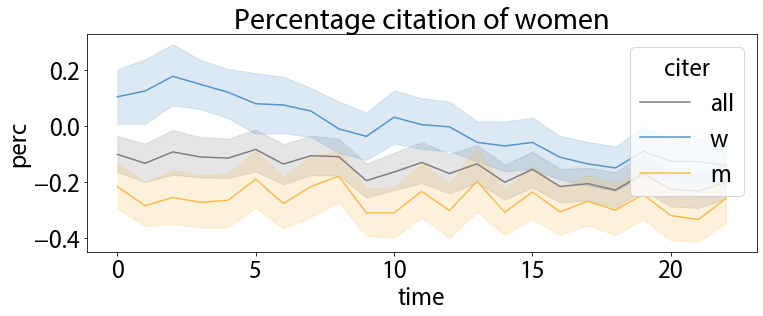

In [28]:
cite_data = pd.DataFrame(columns=['perc','gen','citer','time'])
for i,b in bibs.items():
    curr_perc = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
    tmp_data = pd.DataFrame({'perc': curr_perc, 
                             'gen':['w']*len(curr_perc),
                             'citer':['all']*len(curr_perc),
                             'time':[i]*len(curr_perc)})
    cite_data = pd.concat([cite_data,tmp_data])
    
for i,b in bibs_w.items():
    curr_perc_w = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
    curr_perc_m = (1 - (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b])) - (1 - percs[i]))/(1 - percs[i])    
    
    # womens citation by gender
    gen = ['w']*len(curr_perc_w)
    gen.extend(['m']*len(curr_perc_m))
    tmp_data = pd.DataFrame({'perc': np.concatenate((curr_perc_w, curr_perc_m)), 
                              'citer':['w']*(len(curr_perc_w)+len(curr_perc_m)),
                              'gen':gen,
                              'time':[i]*(len(curr_perc_w)+len(curr_perc_m))})    
    cite_data = pd.concat([cite_data,tmp_data])
    
for i,b in bibs_m.items():
    curr_perc_w = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
    curr_perc_m = (1 - (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b])) - (1 - percs[i]))/(1 - percs[i])    
    
    # mens citation by gender
    gen = ['w']*len(curr_perc_w)
    gen.extend(['m']*len(curr_perc_m))
    tmp_data = pd.DataFrame({'perc': np.concatenate((curr_perc_w, curr_perc_m)), 
                             'gen':gen, 
                             'citer':['m']*(len(curr_perc_w)+len(curr_perc_m)), 
                             'time':[i]*(len(curr_perc_w)+len(curr_perc_m))})    
    cite_data = pd.concat([cite_data,tmp_data])
    
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=cite_data[cite_data['gen'] == 'w'], x='time', y='perc', hue='citer',ax=ax, palette=['grey',colors[2],colors[3]])
ax.set_title('Percentage citation of women')
plt.savefig('../data/img/all_cite_w_int3.pdf')

In [29]:
# stats
X = sm.add_constant(range(nYears))
y = cite_data[(cite_data['citer'] == 'all') & (cite_data['gen'] == 'w')].groupby('time').mean().values
mod = sm.OLS(y, X)
res = mod.fit()
yw = cite_data[(cite_data['citer'] == 'w') & (cite_data['gen'] == 'w')].groupby('time').mean().values
modw = sm.OLS(yw, X)
resw = modw.fit()
ym = cite_data[(cite_data['citer'] == 'm') & (cite_data['gen'] == 'w')].groupby('time').mean().values
modm = sm.OLS(ym, X)
resm = modm.fit()

print('All citers: ' + str(res.params[1]) + ', ' + str(res.pvalues[1]))
print('W citers: ' + str(resw.params[1]) + ', ' + str(resw.pvalues[1]))
print('M citers: ' + str(resm.params[1]) + ', ' + str(resm.pvalues[1]))

All citers: -0.00597121099690169, 4.197210963115372e-07
W citers: -0.014493702190061651, 3.2047960845811248e-12
M citers: -0.0023842339919903687, 0.08704146360879733


'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


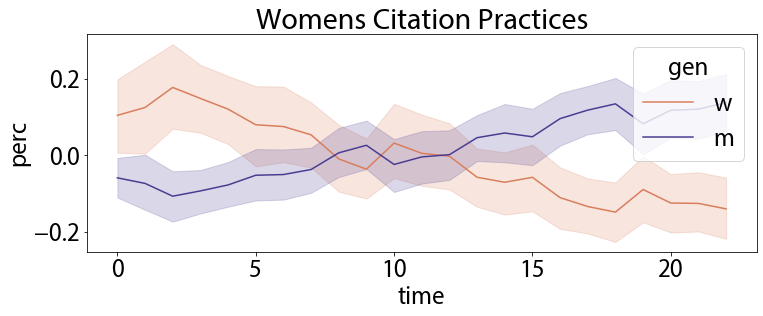

In [30]:
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=cite_data[cite_data['citer'] == 'w'], x='time', y='perc', hue='gen',ax=ax, palette=[colors[0],colors[1]])
ax.set_title('Womens Citation Practices')
plt.savefig('../data/img/w_cite_w_int3.pdf')

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


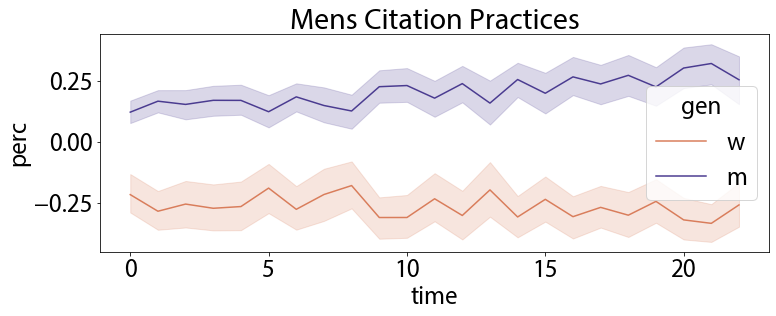

In [31]:
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=cite_data[cite_data['citer'] == 'm'], x='time', y='perc', hue='gen',ax=ax, palette=[colors[0],colors[1]])
ax.set_title('Mens Citation Practices')
plt.savefig('../data/img/m_cite_w_int3.pdf')

#### Parameter sweep

In [47]:
# parameter range we are interested in
parameter = np.linspace(.001,.06,10)
parameter_std = np.linspace(0.00005, 0.005, 10)
statics = []
slopes = []
net_sizes = []
all_meets = []

# generate authors
authors_orig = []
for i in range(700): # we need this to be bigger than the number of authors used in the simulation, to make sure we dont run out when making random draws
    if np.random.rand(1)[0] >= woman_perc_f:
        gen = 'M'
    else:
        gen = 'W'
    # draw biases
    if gen == 'M':
        net = np.random.normal(loc=net_m[0],scale=net_m[1],size=1)[0]
        walk = np.random.normal(loc=walk_m[0],scale=walk_m[1],size=1)[0]
        meet = np.random.normal(loc=meet_m[0],scale=meet_m[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_m[0],sigma=learn_m[1],size=1)[0]
    else:
        net = np.random.normal(loc=net_w[0],scale=net_w[1],size=1)[0]
        walk = np.random.normal(loc=walk_w[0],scale=walk_w[1],size=1)[0]
        meet = np.random.normal(loc=meet_w[0],scale=meet_w[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_w[0],sigma=learn_w[1],size=1)[0]
    # make object
    a = Author(net,walk,meet,learn,gender=gen)
    a.init_network(g,node_2_gender,net_size_o,diam,c)
    authors_orig.append(a)
    
# simulate meetings
w_index = [a.gender == 'W' for a in authors_orig]
w_ind = np.where(w_index)
m_ind = np.where([not x for x in w_index])
ns = np.round(np.linspace(nAuthSt, nAuth, nYears))
ns_w = np.round(ns*np.linspace(woman_perc_i, woman_perc_f, nYears))
# build up time vary parameters, like authors, and gender percentage
# initialize
sim_params = {}
w = np.random.choice(w_ind[0],(1,int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
m = np.random.choice(m_ind[0],(1,nAuthSt - int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
w.extend(m)
sim_params[0] = {'author_idx':w,
                    'woman_perc':woman_perc_i,
                    'n':nAuthSt,}
for i in range(1,nYears):
    new_n = ns[i]
    dn = new_n - sim_params[i-1]['n']
    dw = ns_w[i] - sum([a.gender == 'W' for a in [authors_orig[x] for x in sim_params[i-1]['author_idx']]])
    rem_auths = [j for j,a in enumerate(authors_orig) if j not in sim_params[i-1]['author_idx']]
    new_w_ind = [j for j,a in enumerate(authors_orig) if (j in rem_auths) & (a.gender == 'W')]
    new_m_ind = [j for j,a in enumerate(authors_orig) if (j in rem_auths) & (a.gender == 'M')]
    if dn > 0:
        a = []
        for j in range(int(dn)):
            if j <= dw:
                a.append(np.random.choice(new_w_ind).tolist())
            else:
                a.append(np.random.choice(new_m_ind).tolist())
        new_auths = sim_params[i-1]['author_idx'].copy()
        new_auths.extend(a)
        sim_params[i] = {'author_idx':new_auths,
                        'woman_perc':sum([a.gender == 'W' for a in [authors[x] for x in new_auths]])/new_n,
                        'n':new_n,}
    else:
        sim_params[i] = sim_params[i-1]
        

In [48]:
        
# loop through the new parameters
data_m = Parallel(n_jobs=4)(
    delayed(param_sweep)(authors_orig, 'meet', p, parameter_std, i)
    for i,p in tqdm(enumerate(parameter)) 
)
    

10it [11:49, 70.93s/it]


'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


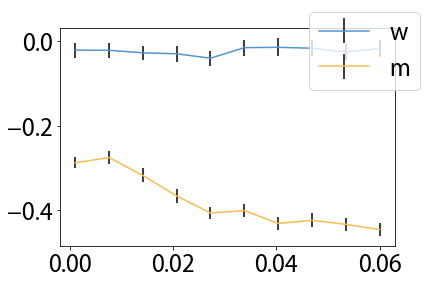

In [49]:
# plot parameter sweep
# static differences over time
statics = [d[1] for d in data_m]
fig = plt.figure(figsize=(6,4))
w_cite = [x[0]['wmu'] for x in statics]
w_err = [x[0]['wstd'] for x in statics]
m_cite = [x[0]['mmu'] for x in statics]
m_err = [x[0]['mstd'] for x in statics]

plt.errorbar(parameter, w_cite, np.abs(np.concatenate((np.array(w_err).reshape(-1,1), 
                                                -np.array(w_err).reshape(-1,1)), axis=1).T), label='w', 
             color=colors[2], ecolor='black')
plt.errorbar(parameter, m_cite, np.abs(np.concatenate((np.array(m_err).reshape(-1,1), 
                                                -np.array(m_err).reshape(-1,1)), axis=1).T), label='m', 
             color=colors[3], ecolor='black')
fig.legend()
plt.savefig('../data/img/static_ps_meet.pdf')

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


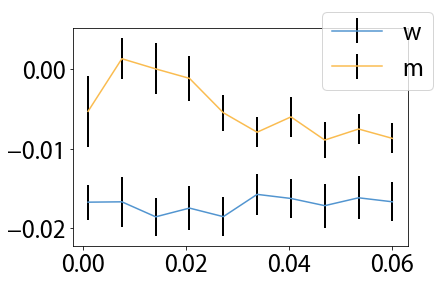

In [50]:
# plot slopes of W cites
slopes = [d[0] for d in data_m]
fig = plt.figure(figsize=(6,4))
w_slope = [x[0]['wslope'] for x in slopes]
w_err = [x[0]['wci'] for x in slopes]
m_slope = [x[0]['mslope'] for x in slopes]
m_err = [x[0]['mci'] for x in slopes]
w_err = np.array(w_err).T - w_slope
m_err = np.array(m_err).T - m_slope

plt.errorbar(parameter, w_slope, np.abs(w_err), label='w', color=colors[2], ecolor='black', elinewidth=2)
plt.errorbar(parameter, m_slope, np.abs(m_err), label='m', color=colors[3], ecolor='black', elinewidth=2)
fig.legend()
plt.savefig('../data/img/tv_ps_meet.pdf')

### Simulate CDS

In [6]:
net_w = (.51,.01)
net_m = (.45,.01)
walk_w = (.60,.1)
walk_m = (.6,.1)
if meet_method == 'soc':
    meet_w = (0.04,0.005)
    meet_m = (0.01,0.0005)
elif meet_method == 'bi':
    meet_w = (0.03,0.005)
    meet_m = (0.03,0.005)
learn_w = (-1,.75)
learn_m = (-1,.75)

meets_per_year = 10

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


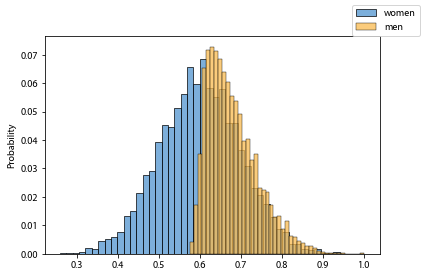

In [7]:
f,ax = plt.subplots(1,1,figsize=(6,4))
sns.histplot(np.random.normal(loc=walk_w[0],scale=walk_w[1],size=5000), color=colors[2], stat='probability')
sns.histplot(skewnorm.rvs(10, loc=walk_m[0],scale=walk_m[1],size=5000), color=colors[3], stat='probability')
f.legend(labels=['women','men'])
plt.savefig('../data/img/beta_cds.pdf')

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


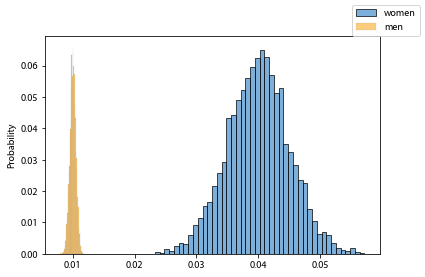

In [8]:
f,ax = plt.subplots(1,1,figsize=(6,4))
sns.histplot(np.random.normal(loc=meet_w[0],scale=meet_w[1],size=5000), color=colors[2], stat='probability')
sns.histplot(np.random.normal(loc=meet_m[0],scale=meet_m[1],size=5000), color=colors[3], stat='probability')
f.legend(labels=['women','men'])
plt.savefig('../data/img/gamma_cds.pdf')

In [9]:
# generate authors
authors = []
for i in range(700): # we need this to be bigger than the number of authors used in the simulation, to make sure we dont run out when making random draws
    if np.random.rand(1)[0] >= woman_perc_f:
        gen = 'M'
    else:
        gen = 'W'
    # draw biases
    if gen == 'M':
        net = np.random.normal(loc=net_m[0],scale=net_m[1],size=1)[0]
        walk = skewnorm.rvs(10, loc=walk_m[0],scale=walk_m[1],size=1)[0]
        meet = np.random.normal(loc=meet_m[0],scale=meet_m[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_m[0],sigma=learn_m[1],size=1)[0]
    else:
        net = np.random.normal(loc=net_w[0],scale=net_w[1],size=1)[0]
        walk = np.random.normal(loc=walk_w[0],scale=walk_w[1],size=1)[0]
        meet = np.random.normal(loc=meet_w[0],scale=meet_w[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_w[0],sigma=learn_w[1],size=1)[0]
    # make object
    a = Author(net,walk,meet,learn,gender=gen)
    a.init_network(g,node_2_gender,net_size_o,diam,c)
    authors.append(a)
    

# simulate meetings
w_index = [a.gender == 'W' for a in authors]
w_ind = np.where(w_index)
m_ind = np.where([not x for x in w_index])
ns = np.round(np.linspace(nAuthSt, nAuth, nYears))
ns_w = np.round(ns*np.linspace(woman_perc_i, woman_perc_f, nYears))
# build up time vary parameters, like authors, and gender percentage
# initialize
sim_params = {}
w = np.random.choice(w_ind[0],(1,int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
m = np.random.choice(m_ind[0],(1,nAuthSt - int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
w.extend(m)
sim_params[0] = {'author_idx':w,
                    'woman_perc':woman_perc_i,
                    'n':nAuthSt,}
for i in range(1,nYears):
    new_n = ns[i]
    dn = new_n - sim_params[i-1]['n']
    dw = ns_w[i] - sum([a.gender == 'W' for a in [authors[x] for x in sim_params[i-1]['author_idx']]])
    rem_auths = [j for j,a in enumerate(authors) if j not in sim_params[i-1]['author_idx']]
    new_w_ind = [j for j,a in enumerate(authors) if (j in rem_auths) & (a.gender == 'W')]
    new_m_ind = [j for j,a in enumerate(authors) if (j in rem_auths) & (a.gender == 'M')]
    if dn > 0:
        a = []
        for j in range(int(dn)):
            if j <= dw:
                a.append(np.random.choice(new_w_ind).tolist())
            else:
                a.append(np.random.choice(new_m_ind).tolist())
        new_auths = sim_params[i-1]['author_idx'].copy()
        new_auths.extend(a)
        sim_params[i] = {'author_idx':new_auths,
                        'woman_perc':sum([a.gender == 'W' for a in [authors[x] for x in new_auths]])/new_n,
                        'n':new_n,}
    else:
        sim_params[i] = sim_params[i-1]

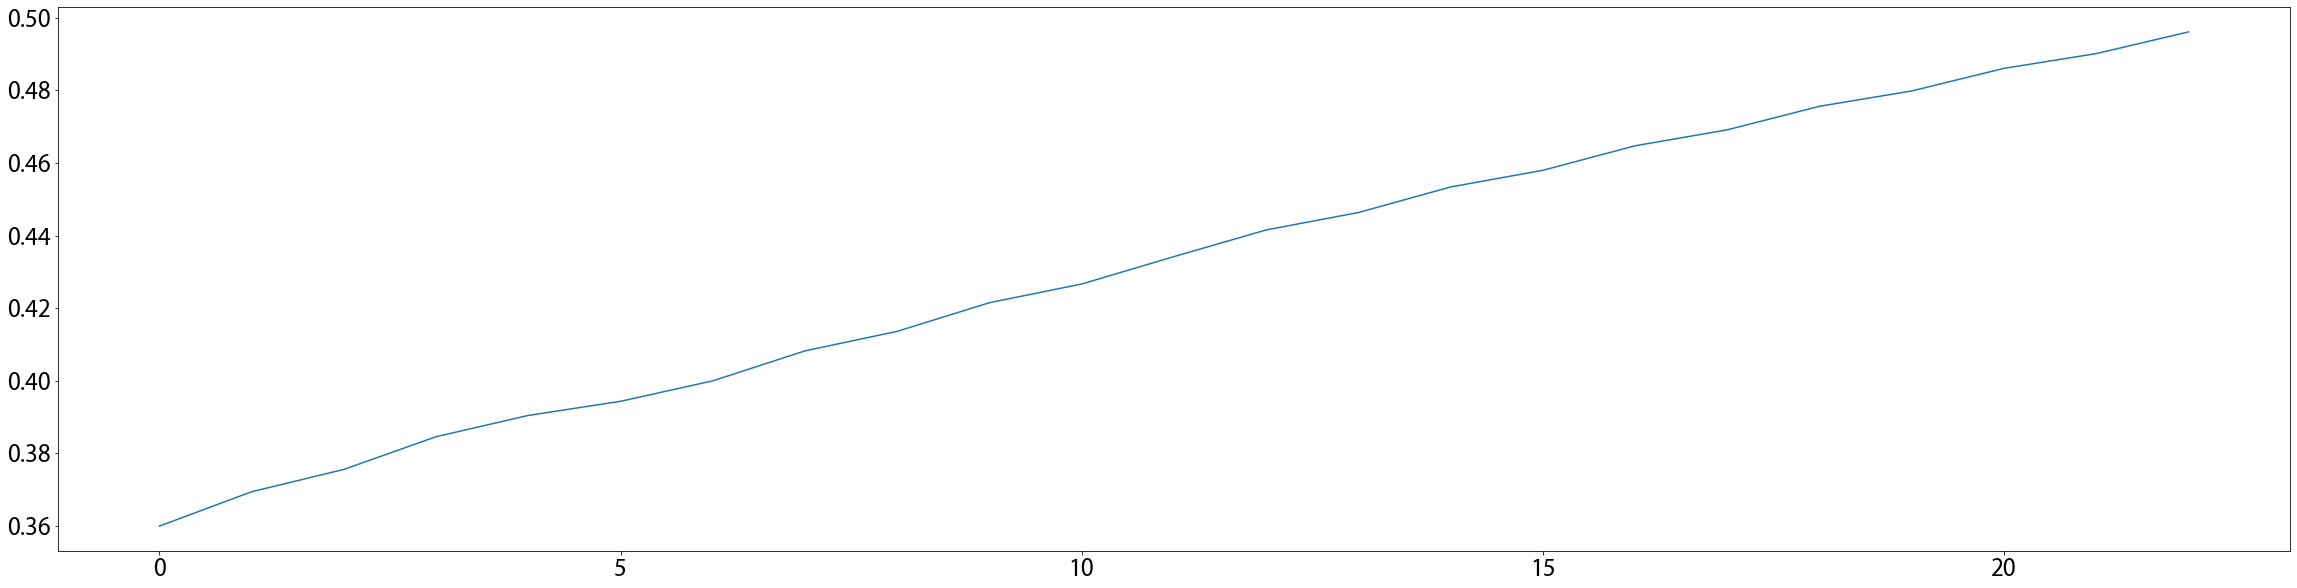

In [10]:
# proportion of women in the field
plt.rcParams.update({'font.size': 25})        
plt.figure(figsize=(40,10))
sns.lineplot(data=[x['woman_perc'] for x in sim_params.values()])

# run simulation
data = []
for i,b in enumerate(range(nYears)):
    #cProfile.run("tmp = group_meet(sim_params[i]['n'], authors, sim_params[i]['author_idx'])")
    tmp = group_meet(sim_params[i]['n'], authors, sim_params[i]['author_idx'], meets_per_year)
    data.append(tmp)
    del tmp

# intialize final data structs
meets = {}; # keep track of when meetings were successful
net_size = []
bibs = {}
bibs_w = {}
bibs_m = {}
cite_perc = []
percs = [x['woman_perc'] for x in sim_params.values()]

# reformat data
cite_data = pd.DataFrame(columns=['perc','gen','time'])
prac_data = pd.DataFrame(columns=['prac','time','gen','citer'])
for i,d in enumerate(data):    
    curr_meets, ns, bs, bws, bms = d
    curr_meets = dict(zip(np.array(list(curr_meets.keys()))+((i)*nAuth),curr_meets.values()))
    meets.update(curr_meets)
    net_size.append(ns)
    bibs[i] = bs
    bibs_w[i] = bws
    bibs_m[i] = bms

Text(0.5, 1.0, 'Different Gender Meetings')

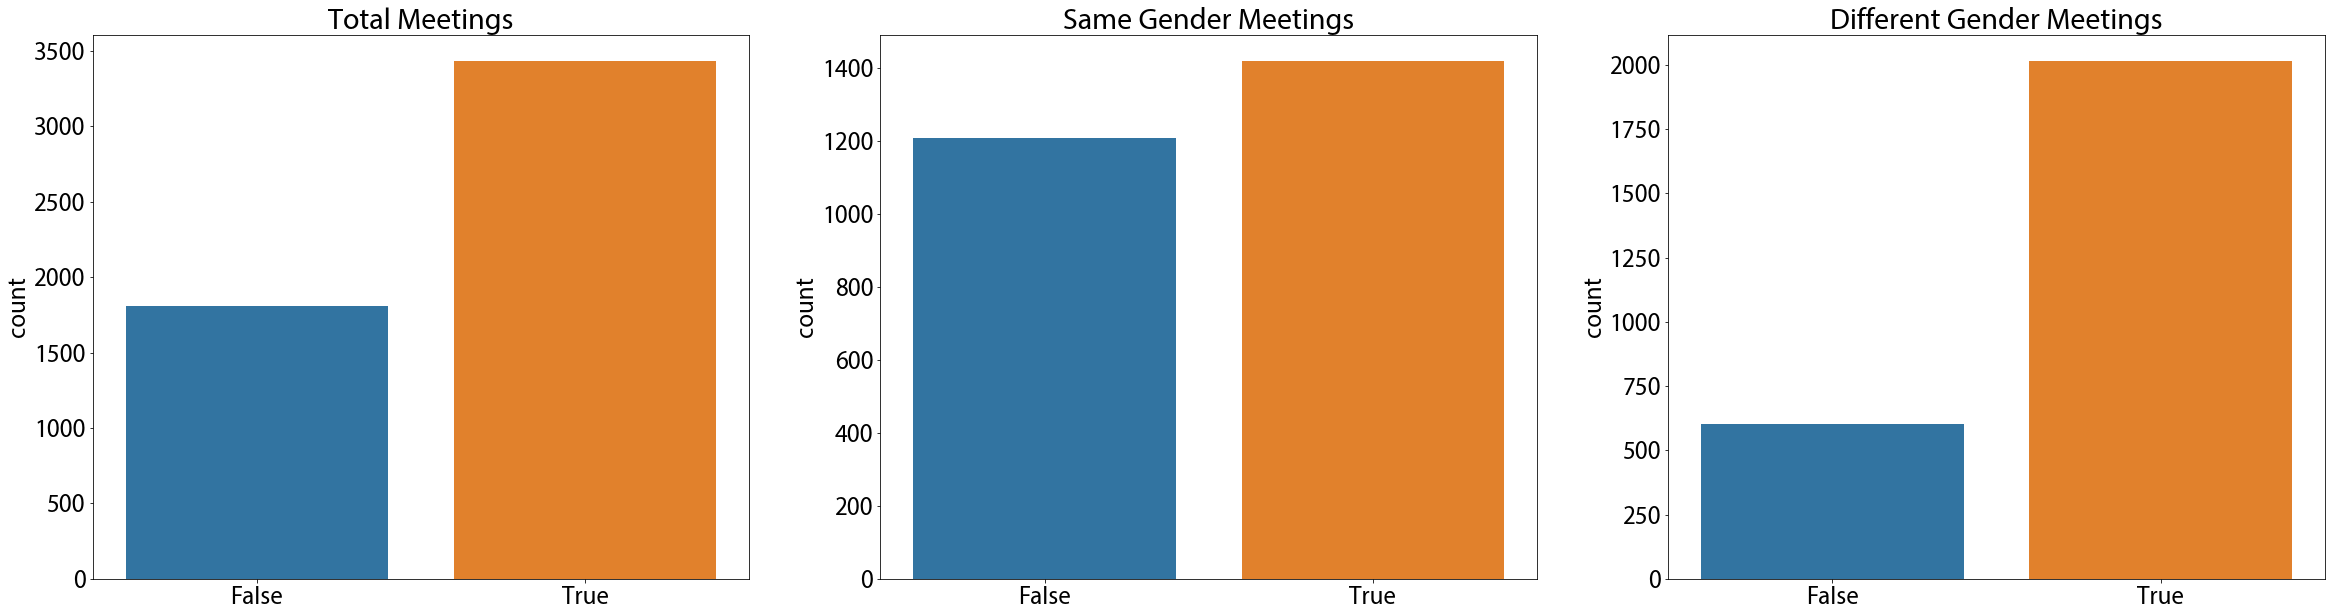

In [11]:
# number of meetings
plt.rcParams.update({'font.size': 25})        
f,ax = plt.subplots(1,3,figsize=(40,10))
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values()], ax=ax[0])
ax[0].set_title('Total Meetings')
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values() 
               if (x['gender1'] == x['gender2'])], ax=ax[1])
ax[1].set_title('Same Gender Meetings')
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values() 
                 if (x['gender1'] != x['gender2'])], ax=ax[2])
ax[2].set_title('Different Gender Meetings')

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


All citers (w): 0.03523641153242637%, +/-0.0342917667712065
All citers (m): -0.015130263586908324%, +/-0.0268255108541827
W citers (w): 0.010132592137560736%, +/-0.030023509852970642
W citers (m): 0.004747890781210902%, +/-0.023659123724887945
M citers (w): 0.054577031336303254%, +/-0.03720295919767999
M citers (m): -0.0304448983836835%, +/-0.028994106340035197


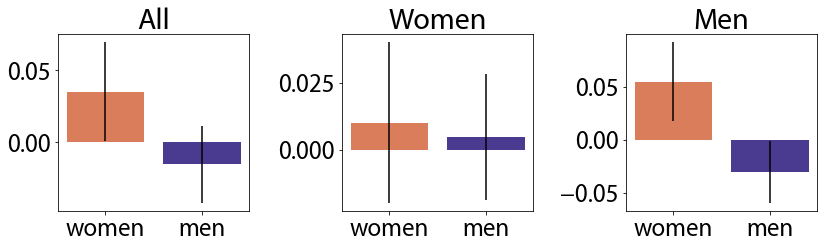

In [12]:
# static plot
static_perc = np.empty((nYears,len(bibs[nYears-1])))
static_perc[:] = np.NaN
static_perc_w = np.empty((nYears,len(bibs_w[nYears-1])))
static_perc_w[:] = np.NaN
static_perc_m = np.empty((nYears,len(bibs_m[nYears-1])))
static_perc_m[:] = np.NaN
for i,b in enumerate(bibs.values()):
    # get all authors citations at this time point
    for j,p in enumerate(b):
        # add to list
        static_perc[i][j] = np.mean([cite['gender'] == 'woman' for cite in p.values()])
        
for i,b in enumerate(bibs_w.values()):
    # get all w authors citations at this time point
    for j,p in enumerate(b):
        # add to list
        static_perc_w[i][j] = np.mean([cite['gender'] == 'woman' for cite in p.values()])

for i,b in enumerate(bibs_m.values()):
    # get all m authors citations at this time point
    for j,p in enumerate(b):
        # add to list
        static_perc_m[i][j] = np.mean([cite['gender'] == 'woman' for cite in p.values()])

plt.figure(figsize=(12,4))

plt.subplot(131)
amw = np.nanmean([(x-percs)/percs for x in static_perc.T])
asw = np.nanstd([(x-percs)/percs for x in static_perc.T])/np.sqrt(len(bibs[nYears-1]))
amm = np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T])
asm = np.nanstd([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T])/np.sqrt(len(bibs[nYears-1]))

plt.bar(['women','men'], [amw, amm], color=colors)
plt.errorbar(['women','men'], [amw,amm], [asw, asm], fmt='none', color='k')
plt.title('All')
print('All citers (w): ' + str(amw) + '%, +/-' + str(asw))
print('All citers (m): ' + str(amm) + '%, +/-' + str(asm))

plt.subplot(132)
wmw = np.nanmean([(x-percs)/percs for x in static_perc_w.T])
wsw = np.nanstd([(x-percs)/percs for x in static_perc_w.T])/np.sqrt(len(bibs[nYears-1]))
wmm = np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T])
wsm = np.nanstd([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T])/np.sqrt(len(bibs[nYears-1]))

plt.bar(['women','men'], [wmw, wmm], color=colors)
plt.errorbar(['women','men'], [wmw,wmm],[wsw,wsm], fmt='none', color='k')
plt.title('Women')
print('W citers (w): ' + str(wmw) + '%, +/-' + str(wsw))
print('W citers (m): ' + str(wmm) + '%, +/-' + str(wsm))

plt.subplot(133)
mmw = np.nanmean([(x-percs)/percs for x in static_perc_m.T])
msw = np.nanstd([(x-percs)/percs for x in static_perc_m.T])/np.sqrt(len(bibs[nYears-1]))
mmm = np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T])
msm = np.nanstd([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T])/np.sqrt(len(bibs[nYears-1]))

plt.bar(['women','men'], [mmw,mmm], color=colors)
plt.errorbar(['women','men'], [mmw,mmm],[msw,msm], fmt='none', color='k')
plt.title('Men')
print('M citers (w): ' + str(mmw) + '%, +/-' + str(msw))
print('M citers (m): ' + str(mmm) + '%, +/-' + str(msm))
plt.tight_layout()
plt.savefig('../data/img/static_cites_cds.pdf')

In [13]:
# stats
wt,wp = ttest_1samp(np.nanmean([(x-percs)/percs for x in static_perc.T],1),0)
mt,mp = ttest_1samp(np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T],1),0)
print('All citers (w): ' + str(wt) + ', ' + str(wp))
print('All citers (m): ' + str(mt) + ', ' + str(mp))

wt,wp = ttest_1samp(np.nanmean([(x-percs)/percs for x in static_perc_w.T],1),0)
mt,mp = ttest_1samp(np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T],1),0)
print('W citers (w): ' + str(wt) + ', ' + str(wp))
print('W citers (m): ' + str(mt) + ', ' + str(mp))

wt,wp = ttest_1samp(np.nanmean([(x-percs)/percs for x in static_perc_m.T],1),0)
mt,mp = ttest_1samp(np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T],1),0)
print('M citers (w): ' + str(wt) + ', ' + str(wp))
print('M citers (m): ' + str(mt) + ', ' + str(mp))

All citers (w): 2.4824205582161345, 0.013693573049320349
All citers (m): -1.1814089366249716, 0.23854093847561905
W citers (w): 0.1244038286582929, 0.9011937917660938
W citers (m): 0.6218245075148784, 0.5351807898671613
M citers (w): 3.9349028355782205, 0.00013577935082153422
M citers (m): -2.844355703610175, 0.005182754840877474


'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


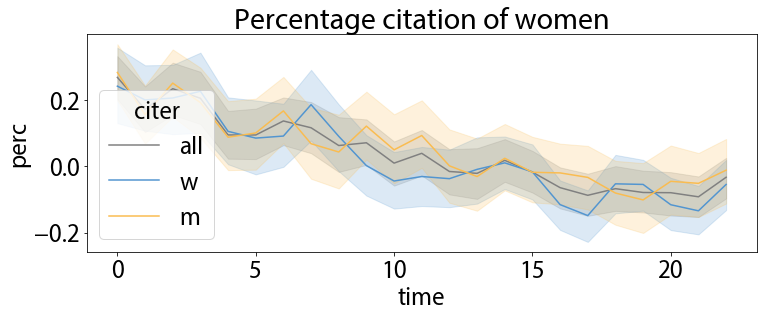

In [14]:
cite_data = pd.DataFrame(columns=['perc','gen','citer','time'])
for i,b in bibs.items():
    curr_perc = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
    tmp_data = pd.DataFrame({'perc': curr_perc, 
                             'gen':['w']*len(curr_perc),
                             'citer':['all']*len(curr_perc),
                             'time':[i]*len(curr_perc)})
    cite_data = pd.concat([cite_data,tmp_data])
    
for i,b in bibs_w.items():
    curr_perc_w = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
    curr_perc_m = (1 - (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b])) - (1 - percs[i]))/(1 - percs[i])    
    
    # womens citation by gender
    gen = ['w']*len(curr_perc_w)
    gen.extend(['m']*len(curr_perc_m))
    tmp_data = pd.DataFrame({'perc': np.concatenate((curr_perc_w, curr_perc_m)), 
                              'citer':['w']*(len(curr_perc_w)+len(curr_perc_m)),
                              'gen':gen,
                              'time':[i]*(len(curr_perc_w)+len(curr_perc_m))})    
    cite_data = pd.concat([cite_data,tmp_data])
    
for i,b in bibs_m.items():
    curr_perc_w = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
    curr_perc_m = (1 - (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b])) - (1 - percs[i]))/(1 - percs[i])    
    
    # mens citation by gender
    gen = ['w']*len(curr_perc_w)
    gen.extend(['m']*len(curr_perc_m))
    tmp_data = pd.DataFrame({'perc': np.concatenate((curr_perc_w, curr_perc_m)), 
                             'gen':gen, 
                             'citer':['m']*(len(curr_perc_w)+len(curr_perc_m)), 
                             'time':[i]*(len(curr_perc_w)+len(curr_perc_m))})    
    cite_data = pd.concat([cite_data,tmp_data])
    
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=cite_data[cite_data['gen'] == 'w'], x='time', y='perc', hue='citer',ax=ax, palette=['grey',colors[2],colors[3]])
ax.set_title('Percentage citation of women')
plt.savefig('../data/img/all_cite_w_cds.pdf')

In [15]:
# stats
X = sm.add_constant(range(nYears))
y = cite_data[(cite_data['citer'] == 'all') & (cite_data['gen'] == 'w')].groupby('time').mean().values
mod = sm.OLS(y, X)
res = mod.fit()
yw = cite_data[(cite_data['citer'] == 'w') & (cite_data['gen'] == 'w')].groupby('time').mean().values
modw = sm.OLS(yw, X)
resw = modw.fit()
ym = cite_data[(cite_data['citer'] == 'm') & (cite_data['gen'] == 'w')].groupby('time').mean().values
modm = sm.OLS(ym, X)
resm = modm.fit()

print('All citers: ' + str(res.params[1]) + ', ' + str(res.pvalues[1]))
print('W citers: ' + str(resw.params[1]) + ', ' + str(resw.pvalues[1]))
print('M citers: ' + str(resm.params[1]) + ', ' + str(resm.pvalues[1]))

All citers: -0.015026635197689143, 4.324230324169799e-11
W citers: -0.016215814409692483, 3.957643427174665e-09
M citers: -0.013873296008478437, 5.8591540590798135e-09


#### Parameter sweep

In [17]:
parameter = np.linspace(0.,.9,9) # percentage of people with new parameters
net_w = (.51,.01)
net_m = (.45,.01)
walk_w = (.60,.1)
walk_m = (.44,.1)
if meet_method == 'soc':
    meet_w = (0.04,0.005)
    meet_m = (0.01,0.0005)
elif meet_method == 'bi':
    meet_w = (0.03,0.005)
    meet_m = (0.03,0.005)
learn_w = (-1,.75)
learn_m = (-1,.75)
statics = []
slopes = []
net_sizes = []
all_meets = []

# generate authors
authors_orig = []
for i in range(700): # we need this to be bigger than the number of authors used in the simulation, to make sure we dont run out when making random draws
    if np.random.rand(1)[0] >= woman_perc_f:
        gen = 'M'
    else:
        gen = 'W'
    # draw biases
    if gen == 'M':
        net = np.random.normal(loc=net_m[0],scale=net_m[1],size=1)[0]
        walk = np.random.normal(loc=walk_m[0],scale=walk_m[1],size=1)[0]
        meet = np.random.normal(loc=meet_m[0],scale=meet_m[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_m[0],sigma=learn_m[1],size=1)[0]
    else:
        net = np.random.normal(loc=net_w[0],scale=net_w[1],size=1)[0]
        walk = np.random.normal(loc=walk_w[0],scale=walk_w[1],size=1)[0]
        meet = np.random.normal(loc=meet_w[0],scale=meet_w[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_w[0],sigma=learn_w[1],size=1)[0]
    # make object
    a = Author(net,walk,meet,learn,gender=gen)
    a.init_network(g,node_2_gender,net_size_o,diam,c)
    authors_orig.append(a)
    
# simulate meetings
w_index = [a.gender == 'W' for a in authors_orig]
w_ind = np.where(w_index)
m_ind = np.where([not x for x in w_index])
ns = np.round(np.linspace(nAuthSt, nAuth, nYears))
ns_w = np.round(ns*np.linspace(woman_perc_i, woman_perc_f, nYears))
# build up time vary parameters, like authors, and gender percentage
# initialize
sim_params = {}
w = np.random.choice(w_ind[0],(1,int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
m = np.random.choice(m_ind[0],(1,nAuthSt - int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
w.extend(m)
sim_params[0] = {'author_idx':w,
                    'woman_perc':woman_perc_i,
                    'n':nAuthSt,}
for i in range(1,nYears):
    new_n = ns[i]
    dn = new_n - sim_params[i-1]['n']
    dw = ns_w[i] - sum([a.gender == 'W' for a in [authors_orig[x] for x in sim_params[i-1]['author_idx']]])
    rem_auths = [j for j,a in enumerate(authors_orig) if j not in sim_params[i-1]['author_idx']]
    new_w_ind = [j for j,a in enumerate(authors_orig) if (j in rem_auths) & (a.gender == 'W')]
    new_m_ind = [j for j,a in enumerate(authors_orig) if (j in rem_auths) & (a.gender == 'M')]
    if dn > 0:
        a = []
        for j in range(int(dn)):
            if j <= dw:
                a.append(np.random.choice(new_w_ind).tolist())
            else:
                a.append(np.random.choice(new_m_ind).tolist())
        new_auths = sim_params[i-1]['author_idx'].copy()
        new_auths.extend(a)
        sim_params[i] = {'author_idx':new_auths,
                        'woman_perc':sum([a.gender == 'W' for a in [authors_orig[x] for x in new_auths]])/new_n,
                        'n':new_n,}
    else:
        sim_params[i] = sim_params[i-1]

                
# loop through the new parameters
data_cds = Parallel(n_jobs=4)(
    delayed(param_sweep)(authors_orig, 'cds', p, np.ones((np.size(parameter),1))*0.1, i)
    for i,p in tqdm(enumerate(parameter)) 
)
    

9it [101:12:31, 40483.47s/it]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/stiso/anaconda2/envs/mod_env/lib/python3.9/site-packages/joblib/parallel.py", line 940, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/Users/stiso/anaconda2/envs/mod_env/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 542, in wrap_future_result
    return future.result(timeout=timeout)
  File "/Users/stiso/anaconda2/envs/mod_env/lib/python3.9/concurrent/futures/_base.py", line 435, in result
    self._condition.wait(timeout)
  File "/Users/stiso/anaconda2/envs/mod_env/lib/python3.9/threading.py", line 312, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/stiso/anaconda2/envs/mod_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-bb224d936d30>", line 81, in <mo

TypeError: object of type 'NoneType' has no len()

In [18]:
# plot parameter sweep
# static differences over time
statics = [d[1] for d in data_cds]
fig = plt.figure(figsize=(6,4))
w_cite = [x[0]['wmu'] for x in statics]
w_err = [x[0]['wstd'] for x in statics]
m_cite = [x[0]['mmu'] for x in statics]
m_err = [x[0]['mstd'] for x in statics]

plt.errorbar(parameter, w_cite, np.abs(np.concatenate((np.array(w_err).reshape(-1,1), 
                                                -np.array(w_err).reshape(-1,1)), axis=1).T), label='w', 
             color=colors[2], ecolor='black')
plt.errorbar(parameter, m_cite, np.abs(np.concatenate((np.array(m_err).reshape(-1,1), 
                                                -np.array(m_err).reshape(-1,1)), axis=1).T), label='m', 
             color=colors[3], ecolor='black')
fig.legend()
plt.savefig('../data/img/static_ps_cds20.pdf')

NameError: name 'data_cds' is not defined

In [ ]:
# plot slopes of W cites
slopes = [d[0] for d in data_cds]
fig = plt.figure(figsize=(6,4))
w_slope = [x[0]['wslope'] for x in slopes]
w_err = [x[0]['wci'] for x in slopes]
m_slope = [x[0]['mslope'] for x in slopes]
m_err = [x[0]['mci'] for x in slopes]
w_err = np.array(w_err).T - w_slope
m_err = np.array(m_err).T - m_slope

plt.errorbar(parameter, w_slope, np.abs(w_err), label='w', color=colors[2], ecolor='black', elinewidth=2)
plt.errorbar(parameter, m_slope, np.abs(m_err), label='m', color=colors[3], ecolor='black', elinewidth=2)
fig.legend()
plt.savefig('../data/img/tv_ps_cds20.pdf')